In [1]:
# É necessário instalar todas as bibliotecas importadas aqui, incluido scikit-learn.
# Para as requisições e geração do mapa, é necessário o acesso a internet.

import numpy as np
import pandas as pd
import matplotlib

import networkx as nx
import osmnx as ox
import folium

import requests
import json

import random as r

In [2]:
# Download do mapa de grafos de Santos através da biblioteca osmnx
try:
    G = ox.load_graphml('grafo.graphml')
    print('A informação do mapa foi lida e o grafo foi criado.')
except:
    G = ox.graph_from_place(('Santos, Brazil'), network_type="drive", simplify=True)
    ox.save_graphml(G, filepath='grafo.graphml')
    print("Grafo salvo.")
    G = ox.load_graphml('grafo.graphml')
    print('A informação do mapa foi lida e o grafo foi criado.')

A informação do mapa foi lida e o grafo foi criado.


In [3]:
# extraindo grafos
G = ox.graph_from_place(('Santos, Brazil'), network_type="drive", simplify=True)

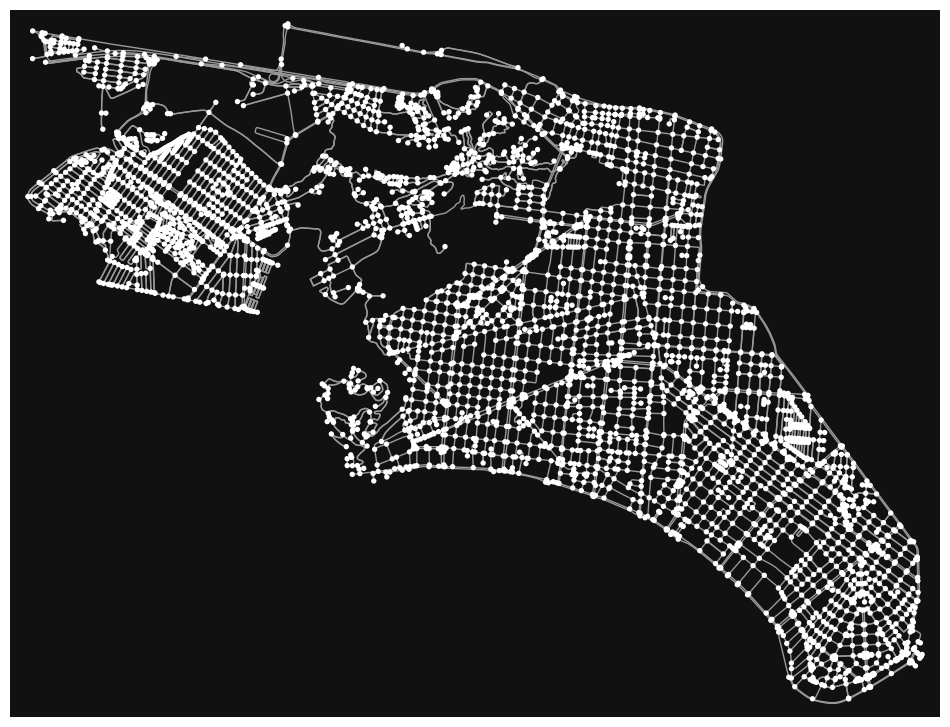

In [4]:
fig, ax = ox.plot_graph(G,figsize=(12,12))

In [5]:
# cria um request para pegar os nós que possuem "Santos" como nome e salva o json
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["name"="Santos"]->.a;
(
  node["name"](area.a);
);

out center;                                                                                                                       
"""

response = requests.get(overpass_url,params={'data': overpass_query})
data = response.json()

with open('santos.json', 'w') as outfile:
    json.dump(data, outfile)

In [6]:
with open('santos.json', 'r') as f:
    data = json.load(f)

In [7]:
data['elements']

[{'type': 'node',
  'id': 32553121,
  'lat': -23.960833,
  'lon': -46.333889,
  'tags': {'ele': '2',
   'is_in:continent': 'South America',
   'name': 'Santos',
   'name:ru': 'Сантус',
   'place': 'city',
   'population': '434000',
   'ref:LOCODE': 'BRSSZ',
   'wikidata': 'Q81882',
   'wikipedia': 'pt:Santos'}},
 {'type': 'node',
  'id': 460149340,
  'lat': -23.9675923,
  'lon': -46.3332133,
  'tags': {'addr:city': 'Santos',
   'addr:street': 'Praça da Independência',
   'addr:suburb': 'Gonzaga',
   'amenity': 'pharmacy',
   'healthcare': 'pharmacy',
   'name': 'Poupa Farma',
   'opening_hours': 'open'}},
 {'type': 'node',
  'id': 460154758,
  'lat': -23.9690536,
  'lon': -46.3327006,
  'tags': {'addr:street': 'Avenida Anna Costa',
   'name': 'Hotel Parque Balneário',
   'tourism': 'hotel'}},
 {'type': 'node',
  'id': 460199365,
  'lat': -23.9671453,
  'lon': -46.3344149,
  'tags': {'addr:street': 'Avenida Marechal Floriano Peixoto',
   'amenity': 'cinema',
   'name': 'Espaço Unibanco 

In [8]:
# serão usados apenas 30 dos nós
data2 = []
for i in range(30):
    data2.append(data['elements'][i])

In [9]:
len(data['elements'])

668

In [10]:
# trata os dados - dado os nós obtidos através do openstreemaps, utiliza a longitude e latitude
# para pegar os nós equivalentes no mapa(G)
nearest_nodes = []
places = []
all_places = np.array(range(len(data2)))
for place in all_places:
    places.append(place)
    nearest = ox.distance.nearest_nodes(G, X=data2[place]['lon'],Y=data2[place]['lat'])
    nearest_node = G.nodes[nearest]
    nearest_node['id'] = nearest
    nearest_node['name'] = place
    nearest_nodes.append(nearest_node.copy())

len(nearest_nodes)


30

In [11]:
# transformando os dados do último ponto no primeiro
nearest_nodes[29]['y'] = nearest_nodes[0]['y']
nearest_nodes[29]['x'] = nearest_nodes[0]['x']

In [12]:
# cálculo da matriz de distância
distance_matrix = []
for source_node in nearest_nodes:
    distance_row = []
    for target_node in nearest_nodes:
        distance = 0
        # caso G tenha um caminho da origem ao destino, calcula o comprimento do caminho mais curto
        if source_node['id'] != target_node['id'] and nx.has_path(G,source_node['id'],target_node['id']):
            distance = nx.shortest_path_length(G, source_node['id'], target_node['id'],weight='length', method='dijkstra')
        elif source_node['id'] == target_node['id']:
            distance = 0
        else:
            distance = np.inf
        distance_row.append(distance)
    distance_matrix.append(distance_row)
distance_matrix = np.array(distance_matrix)

distance_matrix

array([[    0.   ,  1101.545,  1743.304,  1462.622,  1093.831,  1734.984,
              inf,  3838.629,  3751.808,  2922.937,  2056.16 ,  1223.307,
         5071.958,  4346.872,  4301.922,  2308.127,   928.765,  2746.733,
         4873.47 ,  6210.764,  7486.769,  8766.641,  2305.96 ,  3987.012,
          706.933,  3214.576,  4287.753,  4190.7  ,  3932.231,   836.448],
       [ 1060.836,     0.   ,   641.759,   959.347,   412.477,   633.439,
              inf,  4558.815,  4471.994,  3643.123,  2788.36 ,  1943.493,
         4034.588,  3317.771,  4229.174,  1270.757,  1698.892,  3516.86 ,
         5643.597,  6980.891,  8256.896,  9536.768,  3038.16 ,  4757.139,
         1477.06 ,  3497.364,  3250.383,  3153.33 ,  4702.358,  1606.575],
       [ 1100.149,   256.41 ,     0.   ,   998.66 ,   451.79 ,   473.726,
              inf,  4598.128,  4511.307,  3682.436,  2827.673,  1982.806,
         4073.901,  3357.084,  4268.487,  1310.07 ,  1738.205,  3556.173,
         5682.91 ,  7020.204,  8296.

In [13]:
# Salvando a matriz de distância
matrizdistancia = pd.DataFrame(distance_matrix)
matrizdistancia.to_excel('matrizdistancia.xlsx') 
matrizdistancia.head()

0         1         2         3         4         5    6         7   \
0     0.000  1101.545  1743.304  1462.622  1093.831  1734.984  inf  3838.629   
1  1060.836     0.000   641.759   959.347   412.477   633.439  inf  4558.815   
2  1100.149   256.410     0.000   998.660   451.790   473.726  inf  4598.128   
3  1149.119    88.283   730.042     0.000   500.760   721.722  inf  4647.098   
4   717.492   359.689  1001.448   935.804     0.000   993.128  inf  4146.338   

         8         9   ...        20        21        22        23        24  \
0  3751.808  2922.937  ...  7486.769  8766.641  2305.960  3987.012   706.933   
1  4471.994  3643.123  ...  8256.896  9536.768  3038.160  4757.139  1477.060   
2  4511.307  3682.436  ...  8296.209  9576.081  3077.473  4796.452  1516.373   
3  4560.277  3731.406  ...  8345.179  9625.051  3126.443  4845.422  1565.343   
4  4059.517  3230.646  ...  8039.352  9319.224  2625.683  4383.372  1252.125   

         25        26        27        28        29  
0  3214.576  4287.753  4190.700  3932.231   836.448  
1  3497.364  3250.383  3153.330  4702.358  1606.575  
2  3536.677  3189.514  3192.643  4741.671  1645.888  
3  3585.647  3338.666  3241.613  4790.641  1694.858  
4  3481.023  3610.072  3513.019  4328.591  1389.031  

[5 rows x 30 columns]

In [14]:
# Convertendo a matriz de distância para matriz de tempo a partir da velocidade
# Definindo a velocidade como 50km/h, porém, para os cálculos, é preciso converter para m/min (833)
kmh_to_meterpermin = 833
time_matrix = distance_matrix/kmh_to_meterpermin

# Imprime a matriz de tempo
time_matrix

array([[ 0.        ,  1.32238295,  2.09280192,  1.75584874,  1.31312245,
         2.08281393,         inf,  4.60819808,  4.50397119,  3.50892797,
         2.46837935,  1.46855582,  6.08878511,  5.21833373,  5.16437215,
         2.77086074,  1.11496399,  3.29739856,  5.8505042 ,  7.45589916,
         8.98771789, 10.52417887,  2.7682593 ,  4.78632893,  0.84865906,
         3.85903481,  5.14736255,  5.03085234,  4.72056543,  1.00413926],
       [ 1.27351261,  0.        ,  0.77041897,  1.15167707,  0.49517047,
         0.76043097,         inf,  5.47276711,  5.36854022,  4.373497  ,
         3.34737095,  2.33312485,  4.84344298,  3.98291837,  5.07703962,
         1.52551861,  2.03948619,  4.22192077,  6.77502641,  8.38042137,
         9.9122401 , 11.44870108,  3.6472509 ,  5.71085114,  1.77318127,
         4.19851621,  3.90202041,  3.7855102 ,  5.64508764,  1.92866146],
       [ 1.32070708,  0.30781513,  0.        ,  1.19887155,  0.54236495,
         0.56869868,         inf,  5.51996158,  5

In [15]:
# Cria o ambiente e matriz de feromônios
def create_environment(time_matrix, stops, eps = 0.0001):
    N = len(stops)
    def pheromone_matrix(stops, eps = eps):
        N =len(stops)
        data = (np.ones((N,N))- np.eye(N)) / (N-1) 
        phe = pd.DataFrame(data=data, columns = stops, index = stops) 
        return phe.loc[~phe.index.duplicated(),~phe.columns.duplicated()]
    env = pd.DataFrame(time_matrix, columns = stops, index = stops) 
    return env.loc[~env.index.duplicated(),~env.columns.duplicated()], pheromone_matrix(stops)

env, phe = create_environment(time_matrix = time_matrix, stops = places)

In [16]:
# implementação da classe formiga
class Ant():
    def __init__(self, env, phe, weights, start, end, capacity, alpha = 1, beta = 1,
                 time_constraint = 100, time_spent = 1): 
    # env - matriz de ambiente
    # phe - matriz de feromônios
    # weights - lista de pesos por parada
    # start - ponto inicial
    # end - ponto final
    # capacity - capacidade da mochila
    # alpha - tamanho de influência do feromônio
    # beta - tamanho de influência do tempo
    # time_constraint - limite de tempo
    # time_spent - tempo gasto em cada parada nas casas

        self.outliers = []
        self.time_constraint = time_constraint
        self.time_spent = time_spent
        self.weights = weights
        self.capacity = capacity
        self.phe  = phe
        self.env = self.outlier(env)
        self.alpha, self.beta = alpha, beta
        self.stops = list(self.env.columns) 
        self.current_stop = start 
        self.depot = end   
        self.start = start 
        
        self.route = [self.current_stop,self.depot] 
        self.possible_stops = self.stops.copy() 
        self.possible_stops.remove(self.current_stop) 
        self.possible_stops.remove(self.depot)

    # calcula as informações de custo em termos de tempo
    @staticmethod
    def cost_time(route, time_spent, en):
        result = 0
        for i in range(len(route)-1): 
            result += en.loc[route[i], route[i+1]] 
                                                                                  
        result+= (len(route)-2)*time_spent #tempo da rota + tempo de espera por parada 
        print('route:',route)
        print('cost_time:',result)
        return result

    # calcula as informações de custo em termos de capacidade da mochila
    @staticmethod
    def cost_capacity(route, weights): 
        result = 0
        for i in range(len(route)):
            result += weights[route[i]] 
        print('cost_capacity:',result)
        return result
       
    # calcula o passo da formiga
    def move(self): 
        '''
        Add a parada atual na rota, retira das paradas possíveis, calcula o custo de tempo e capacidade
        Se os custos foram menores que os limites, então inicia outra rota, 
        se não, retira a última parada, calcula o custo novamente e inicia outra rota.
        '''
        if len(self.possible_stops) == 0: 
           return
        distances = self.env.loc[self.current_stop][self.possible_stops] 
        pheromones = self.phe.loc[self.current_stop][self.possible_stops] 
        distances[distances == 0] = 1 
        # cálculo da preferência
        preferences = pheromones**self.alpha/distances**self.beta
        # cálculo da probabilidade
        probabilities = preferences/preferences.sum() 
        probabilities.dropna(inplace=True) 
        # escolhe uma parada aleatoriamente levando em consideração a probabilidade
        self.current_stop = np.random.choice(a = probabilities.index, size=1, p = probabilities.values)[0]
        self.route.insert(-1,self.current_stop) 
        self.possible_stops.remove(self.current_stop) 
        temp_route = np.array(self.route) 
        current_depot = np.where(temp_route == self.start)[0][-1] 
        #calcula o custo (tempo) a partir do deposito atual pra frente
        c_time = Ant.cost_time(self.route[current_depot:], self.time_spent, self.env)
        #calcula o custo a partir do deposito atual pra frente
        c_capacity = Ant.cost_capacity(self.route[current_depot:], self.weights)
        #se custo(tempo)>limite diário ou custo>capacidade, retira a parada
        if c_time > self.time_constraint or c_capacity > self.capacity: 
            self.route.pop(-2)    
            self.possible_stops.append(self.current_stop) 
            #calcula o custo (tempo) a partir do deposito atual pra frente
            c_time = Ant.cost_time(self.route[current_depot:], self.time_spent, self.env) 
            #calcula o custo (peso) a partir do deposito atual pra frente
            c_capacity = Ant.cost_capacity(self.route[current_depot:], self.weights) 
            if c_time <= self.time_constraint and c_capacity <= self.capacity:
                self.route.append(self.start)   
                self.current_stop = self.start  
                self.route.append(self.depot)   
            else:
                return
    
    
    # fica chamando o método move até que todos os pontos sejam percorridos
    def go(self): 
        while len(self.possible_stops) != 0: 
            self.move()

    
    # retorna informações de rota
    def deposit(self): 
        return self.route   
 

    # encontra outliers
    # outliers são pontos que ficam distantes demais para ir dentro do tempo limite, ou impossíveis de serem alcançados
    def outlier(self, en):  
        control = []       
        for i,_ in enumerate(en.index.values):
            cost_temp = Ant.cost_time([en.index[0],en.index[i]], self.time_spent,en)
            if type(cost_temp) == pd.core.series.Series:
                control.append(cost_temp[0])
            else:
                control.append(cost_temp)
        control_np = np.array(control)
        out = en.index.values[control_np>self.time_constraint]
        self.outliers.append(out)
        en = en.drop(out, axis=1)    
        en = en.drop(out, axis=0)
        return en

In [17]:
# Implementação da classe AntColony
class AntColony():
    def __init__(self, time_matrix, weights, stops, start, end, capacity,
                 time_constraint = 100, time_spent = 1):
        
        self.weights = weights
        self.capacity = capacity
        self.stops = stops
        self.start = start  
        self.end = end  
        self.env, self.phe = create_environment(time_matrix, stops = stops)
        self.time_constraint = time_constraint
        self.time_spent = time_spent


    # atualiza o valor do feromônio após evaporação
    def evaporation(self, decay = 0.05): 
        self.phe = self.phe * (1 - decay) 


    # deposita o feromônio
    # delta - constante de atualização do feromônio
    def deposit(self, route, delta = 1): 
        self.env[self.env == 0] = 10**-6 
        for i,j in zip(route[:-1], route[1:]):   
            self.phe.loc[i, j] +=  delta/self.env.loc[i, j] 


    # constrói a colônia e chama o 'move' para cada formiga
    # k - quantidade de formigas
    # time - n de vezes que cada formiga vai se mover
    def run(self, K, time): 
        for t in range(time):    
            self.colony = [Ant(env = self.env, phe = self.phe, weights = self.weights, capacity = self.capacity,
                          start = self.start, end = self.end, alpha = 1, beta = 1, time_constraint = self.time_constraint, time_spent = self.time_spent) 
                      for k in range(K)] 
            for k in range(K):
                self.colony[k].go()   
            for k in range(K): 
                path = self.colony[k].deposit()   
                self.deposit(route = path)
            self.evaporation()

In [18]:
# Implementação da classe TimeDependentVRP - Vehicle Routing Problem

class TimeDependentVRP():
    def __init__(self, Swarm, K = 40, Time = 10): 
        self.swarm = Swarm       
        self.swarm.run(K,Time) 


    # retorna a colônia
    def getSwarm(self):
        return self.swarm


    # imprime detalhes
    def printDetails(self, routes, routes_cost, routes_capacity, outliers): 
        count = 1
        for r,t,c in zip(routes, routes_cost, routes_capacity): 
            print('Rota ' + str(count) + ': ' + str(r) + ' Tempo: ' + str(round(t)) + ' minutos; '+ ' Capacidade: ' + str(c) + ' pedidos; ', end='\n\n')
            count+=1
        print('Tempo total: ' + str(round(np.sum(routes_cost),2)) + ' minutos', end='\n\n') 
        print('Outliers: ' + str(outliers)) 

    # prepara os resultados para a impressão
    def getResult(self, getAsDataFrame = True):
        # resultado do custo por formiga
        results_dist = [Ant.cost_time(a.route, a.time_spent, a.env) for a in self.swarm.colony]
        # retorna o indice do menor result_dist, isso é, formiga com menor custo  
        min_result_index = np.argmin(results_dist)
        # array com as rotas encontradas da melhor formiga
        best_routes = np.array(self.swarm.colony[min_result_index].route)
        # array com os outliers da melhor formiga 
        outliers = np.array(self.swarm.colony[min_result_index].outliers[0])
        # start da melhor formiga 
        start = self.swarm.colony[min_result_index].start
        # array com os índices dos pontos de start
        start_points = np.where(best_routes == self.swarm.start)[0] 
        # array com os índices dos pontos de depósito
        depot_points = np.where(best_routes == self.swarm.end)[0] 
        route_ranges = [range(start_points[i],depot_points[i]+1) for i in range(len(depot_points))]  
        routes = [best_routes[route_ranges[i]].tolist() for i in range(len(route_ranges))] 
        # calcula o custo(tempo) de cada rota separadamente
        routes_cost = [Ant.cost_time(routes[i][:],     
                      self.swarm.colony[min_result_index].time_spent, 
                      self.swarm.colony[min_result_index].env) for i in range(len(routes))]
        # calcula o custo de cada rota separadamente
        routes_capacity = [Ant.cost_capacity(routes[i][:],           
                          self.swarm.colony[min_result_index].weights) for i in range(len(routes))]
        # chama função para imprimir rota, custo, capacide e outliers
        self.printDetails(routes, routes_cost, routes_capacity, outliers) 
        
        if getAsDataFrame == True:
          df = pd.DataFrame([routes, routes_cost, routes_capacity], index = ['Rota','Tempo (min)','Capacidade']).T   #gera um df
          df['Tempo (min)']=df['Tempo (min)'].apply(lambda x: round(x))
          return df

In [19]:
orders = []
for i in range(30):
    orders.append(r.randint(1,5))

In [20]:
# Definição dos parâmetros

limit_time = 120 # limite de tempo por rota
time_spent = 1 # tempo de espera em cada parada 
start = nearest_nodes[0]['name'] #ponto de partida da rota
end = nearest_nodes[29]['name'] #ponto de chegada da rota
capacity = orders # quantidade de pedidos por parada
max_capacity = 30 # demanda máxima de entregas

# Instância do AntColony e TimeDependentVRP
swarm = AntColony(time_matrix = time_matrix, stops = places, start = start, end = end, 
                  time_constraint = limit_time, time_spent = time_spent, weights = capacity, capacity = max_capacity)

VRP = TimeDependentVRP(swarm, K = 50, Time = 10) 
df = VRP.getResult()

route: [0, 0]
cost_time: 0.0
route: [0, 1]
cost_time: 1.3223829531812725
route: [0, 2]
cost_time: 2.0928019207683075
route: [0, 3]
cost_time: 1.7558487394957984
route: [0, 4]
cost_time: 1.3131224489795916
route: [0, 5]
cost_time: 2.082813925570228
route: [0, 6]
cost_time: inf
route: [0, 7]
cost_time: 4.608198079231692
route: [0, 8]
cost_time: 4.503971188475389
route: [0, 9]
cost_time: 3.508927971188475
route: [0, 10]
cost_time: 2.4683793517406967
route: [0, 11]
cost_time: 1.4685558223289312
route: [0, 12]
cost_time: 6.088785114045619
route: [0, 13]
cost_time: 5.218333733493397
route: [0, 14]
cost_time: 5.164372148859544
route: [0, 15]
cost_time: 2.770860744297719
route: [0, 16]
cost_time: 1.1149639855942377
route: [0, 17]
cost_time: 3.29739855942377
route: [0, 18]
cost_time: 5.850504201680674
route: [0, 19]
cost_time: 7.455899159663863
route: [0, 20]
cost_time: 8.98771788715486
route: [0, 21]
cost_time: 10.524178871548619
route: [0, 22]
cost_time: 2.7682593037214893
route: [0, 23]
cost

route: [0, 2, 14, 13, 27, 22, 25, 18, 29]
cost_time: 41.79945258103241
cost_capacity: 28
route: [0, 2, 14, 13, 27, 22, 25, 18, 12, 29]
cost_time: 56.25502400960384
cost_capacity: 32
route: [0, 2, 14, 13, 27, 22, 25, 18, 29]
cost_time: 41.79945258103241
cost_capacity: 28
route: [0, 17, 29]
cost_time: 6.598026410564226
cost_capacity: 7
route: [0, 17, 23, 29]
cost_time: 11.356535414165666
cost_capacity: 11
route: [0, 17, 23, 7, 29]
cost_time: 12.971048019207682
cost_capacity: 16
route: [0, 17, 23, 7, 28, 29]
cost_time: 14.732207683073227
cost_capacity: 17
route: [0, 17, 23, 7, 28, 26, 29]
cost_time: 26.762866746698677
cost_capacity: 22
route: [0, 17, 23, 7, 28, 26, 20, 29]
cost_time: 44.0535450180072
cost_capacity: 23
route: [0, 17, 23, 7, 28, 26, 20, 21, 29]
cost_time: 49.076654261704675
cost_capacity: 25
route: [0, 17, 23, 7, 28, 26, 20, 21, 15, 29]
cost_time: 55.775648259303715
cost_capacity: 28
route: [0, 17, 23, 7, 28, 26, 20, 21, 15, 3, 29]
cost_time: 58.36722208883553
cost_capacity

route: [0, 15, 9, 24, 11, 18, 22, 16, 29]
cost_time: 31.716669867947182
cost_capacity: 28
route: [0, 15, 9, 24, 11, 18, 22, 16, 4, 29]
cost_time: 36.296254501800725
cost_capacity: 29
route: [0, 15, 9, 24, 11, 18, 22, 16, 4, 5, 29]
cost_time: 39.2277887154862
cost_capacity: 32
route: [0, 15, 9, 24, 11, 18, 22, 16, 4, 29]
cost_time: 36.296254501800725
cost_capacity: 29
route: [0, 17, 29]
cost_time: 6.598026410564226
cost_capacity: 7
route: [0, 17, 28, 29]
cost_time: 11.38757262905162
cost_capacity: 8
route: [0, 17, 28, 13, 29]
cost_time: 23.241615846338533
cost_capacity: 9
route: [0, 17, 28, 13, 27, 29]
cost_time: 24.24161584633853
cost_capacity: 14
route: [0, 17, 28, 13, 27, 12, 29]
cost_time: 28.131941176470587
cost_capacity: 18
route: [0, 17, 28, 13, 27, 12, 2, 29]
cost_time: 29.17756902761104
cost_capacity: 22
route: [0, 17, 28, 13, 27, 12, 2, 20, 29]
cost_time: 46.468247298919565
cost_capacity: 23
route: [0, 17, 28, 13, 27, 12, 2, 20, 21, 29]
cost_time: 51.49135654261704
cost_capaci

route: [0, 13, 15, 29]
cost_time: 13.220762304921971
cost_capacity: 7
route: [0, 13, 15, 7, 29]
cost_time: 20.103699879951982
cost_capacity: 12
route: [0, 13, 15, 7, 21, 29]
cost_time: 34.87228451380552
cost_capacity: 14
route: [0, 15, 29]
cost_time: 6.597542617046819
cost_capacity: 6
route: [0, 15, 22, 29]
cost_time: 11.149504201680674
cost_capacity: 10
route: [0, 15, 22, 18, 29]
cost_time: 18.074470588235297
cost_capacity: 15
route: [0, 15, 22, 18, 25, 29]
cost_time: 26.69444777911165
cost_capacity: 19
route: [0, 15, 22, 18, 25, 5, 29]
cost_time: 29.911657863145262
cost_capacity: 22
route: [0, 15, 22, 18, 25, 5, 2, 29]
cost_time: 30.926342136854743
cost_capacity: 26
route: [0, 15, 22, 18, 25, 5, 2, 4, 29]
cost_time: 32.16035534213685
cost_capacity: 27
route: [0, 15, 22, 18, 25, 5, 2, 4, 20, 29]
cost_time: 49.45103361344538
cost_capacity: 28
route: [0, 15, 22, 18, 25, 5, 2, 4, 20, 7, 29]
cost_time: 52.16621728691477
cost_capacity: 33
route: [0, 15, 22, 18, 25, 5, 2, 4, 20, 29]
cost_ti

route: [0, 24, 22, 17, 5, 15, 13, 27, 26, 29]
cost_time: 29.396679471788712
cost_capacity: 31
route: [0, 24, 22, 17, 5, 15, 13, 27, 29]
cost_time: 27.32068307322929
cost_capacity: 26
route: [0, 21, 29]
cost_time: 21.204280912364943
cost_capacity: 5
route: [0, 21, 9, 29]
cost_time: 24.503495798319328
cost_capacity: 9
route: [0, 21, 9, 26, 29]
cost_time: 34.333998799519804
cost_capacity: 14
route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 7, 29]
cost_time: 11.006806722689078
cost_capacity: 11
route: [0, 24, 7, 22, 29]
cost_time: 13.005867947178874
cost_capacity: 15
route: [0, 24, 7, 22, 2, 29]
cost_time: 18.43305642256903
cost_capacity: 19
route: [0, 24, 7, 22, 2, 1, 29]
cost_time: 19.693677070828333
cost_capacity: 24
route: [0, 24, 7, 22, 2, 1, 4, 29]
cost_time: 20.927690276110447
cost_capacity: 25
route: [0, 24, 7, 22, 2, 1, 4, 16, 29]
cost_time: 22.259111644657864
cost_capacity: 26
route: [0, 24, 7, 22, 2, 1, 4, 16, 18, 29]
cost_time: 32.951572629051626
c

route: [0, 5, 15, 12, 9, 3, 10, 22, 19, 29]
cost_time: 44.214128451380546
cost_capacity: 27
route: [0, 5, 15, 12, 9, 3, 10, 22, 19, 8, 29]
cost_time: 48.78563145258103
cost_capacity: 31
route: [0, 5, 15, 12, 9, 3, 10, 22, 19, 29]
cost_time: 44.214128451380546
cost_capacity: 27
route: [0, 2, 29]
cost_time: 5.068657863145258
cost_capacity: 7
route: [0, 2, 1, 29]
cost_time: 6.329278511404562
cost_capacity: 12
route: [0, 2, 1, 17, 29]
cost_time: 11.923165666266506
cost_capacity: 16
route: [0, 2, 1, 17, 18, 29]
cost_time: 18.021739495798318
cost_capacity: 21
route: [0, 2, 1, 17, 18, 21, 29]
cost_time: 31.95002040816326
cost_capacity: 23
route: [0, 2, 1, 17, 18, 21, 20, 29]
cost_time: 34.20683913565426
cost_capacity: 24
route: [0, 2, 1, 17, 18, 21, 20, 28, 29]
cost_time: 36.39378271308524
cost_capacity: 25
route: [0, 2, 1, 17, 18, 21, 20, 28, 26, 29]
cost_time: 48.42444177671069
cost_capacity: 30
route: [0, 2, 1, 17, 18, 21, 20, 28, 26, 25, 29]
cost_time: 52.195546218487394
cost_capacity: 34

route: [0, 10, 3, 1, 2, 4, 29]
cost_time: 14.27747298919568
cost_capacity: 18
route: [0, 10, 3, 1, 2, 4, 23, 29]
cost_time: 22.54788355342137
cost_capacity: 22
route: [0, 10, 3, 1, 2, 4, 23, 9, 29]
cost_time: 25.25840336134454
cost_capacity: 26
route: [0, 10, 3, 1, 2, 4, 23, 9, 8, 29]
cost_time: 28.86963025210084
cost_capacity: 30
route: [0, 10, 3, 1, 2, 4, 23, 9, 8, 17, 29]
cost_time: 30.404106842737093
cost_capacity: 34
route: [0, 10, 3, 1, 2, 4, 23, 9, 8, 29]
cost_time: 28.86963025210084
cost_capacity: 30
route: [0, 16, 29]
cost_time: 2.3355606242497
cost_capacity: 4
route: [0, 16, 28, 29]
cost_time: 10.824551020408162
cost_capacity: 5
route: [0, 16, 28, 20, 29]
cost_time: 21.8704693877551
cost_capacity: 6
route: [0, 16, 28, 20, 21, 29]
cost_time: 26.893578631452577
cost_capacity: 8
route: [0, 16, 28, 20, 21, 17, 29]
cost_time: 28.243847539015604
cost_capacity: 12
route: [0, 16, 28, 20, 21, 17, 25, 29]
cost_time: 36.86382472989196
cost_capacity: 16
route: [0, 16, 28, 20, 21, 17, 25,

route: [0, 18, 29]
cost_time: 11.69660024009604
cost_capacity: 8
route: [0, 18, 9, 29]
cost_time: 15.383472989195678
cost_capacity: 12
route: [0, 18, 9, 5, 29]
cost_time: 19.758278511404562
cost_capacity: 15
route: [0, 18, 9, 5, 15, 29]
cost_time: 22.90540576230492
cost_capacity: 18
route: [0, 18, 9, 5, 15, 19, 29]
cost_time: 35.22101680672268
cost_capacity: 19
route: [0, 18, 9, 5, 15, 19, 8, 29]
cost_time: 39.79251980792316
cost_capacity: 23
route: [0, 18, 9, 5, 15, 19, 8, 17, 29]
cost_time: 41.326996398559416
cost_capacity: 27
route: [0, 18, 9, 5, 15, 19, 8, 17, 13, 29]
cost_time: 53.420775510204074
cost_capacity: 28
route: [0, 18, 9, 5, 15, 19, 8, 17, 13, 12, 29]
cost_time: 57.311100840336124
cost_capacity: 32
route: [0, 18, 9, 5, 15, 19, 8, 17, 13, 29]
cost_time: 53.420775510204074
cost_capacity: 28
route: [0, 7, 29]
cost_time: 9.342140456182472
cost_capacity: 8
route: [0, 7, 12, 29]
cost_time: 23.068339735894355
cost_capacity: 12
route: [0, 7, 12, 20, 29]
cost_time: 40.35901800720

route: [0, 2, 4, 3, 1, 5, 28, 7, 8, 17, 29]
cost_time: 27.906835534213684
cost_capacity: 31
route: [0, 2, 4, 3, 1, 5, 28, 7, 8, 29]
cost_time: 26.37235894357743
cost_capacity: 27
route: [0, 21, 29]
cost_time: 21.204280912364943
cost_capacity: 5
route: [0, 21, 20, 29]
cost_time: 23.461099639855938
cost_capacity: 6
route: [0, 21, 20, 26, 29]
cost_time: 35.54585594237695
cost_capacity: 11
route: [0, 21, 20, 26, 27, 29]
cost_time: 37.929950780312126
cost_capacity: 16
route: [0, 21, 20, 26, 27, 15, 29]
cost_time: 39.04881152460985
cost_capacity: 19
route: [0, 21, 20, 26, 27, 15, 16, 29]
cost_time: 40.42533973589437
cost_capacity: 20
route: [0, 21, 20, 26, 27, 15, 16, 24, 29]
cost_time: 42.279391356542625
cost_capacity: 23
route: [0, 21, 20, 26, 27, 15, 16, 24, 10, 29]
cost_time: 48.003503001200485
cost_capacity: 27
route: [0, 21, 20, 26, 27, 15, 16, 24, 10, 22, 29]
cost_time: 49.691398559423774
cost_capacity: 31
route: [0, 21, 20, 26, 27, 15, 16, 24, 10, 29]
cost_time: 48.003503001200485
co

route: [0, 24, 3, 16, 29]
cost_time: 8.328326530612244
cost_capacity: 8
route: [0, 24, 3, 16, 19, 29]
cost_time: 21.41401920768307
cost_capacity: 9
route: [0, 24, 3, 16, 19, 8, 29]
cost_time: 25.985522208883552
cost_capacity: 13
route: [0, 24, 3, 16, 19, 8, 7, 29]
cost_time: 27.16972989195678
cost_capacity: 18
route: [0, 24, 3, 16, 19, 8, 7, 23, 29]
cost_time: 28.568534213685474
cost_capacity: 22
route: [0, 24, 3, 16, 19, 8, 7, 23, 10, 29]
cost_time: 30.801990396158462
cost_capacity: 26
route: [0, 24, 3, 16, 19, 8, 7, 23, 10, 22, 29]
cost_time: 32.489885954381755
cost_capacity: 30
route: [0, 24, 3, 16, 19, 8, 7, 23, 10, 22, 21, 29]
cost_time: 49.963865546218486
cost_capacity: 32
route: [0, 24, 3, 16, 19, 8, 7, 23, 10, 22, 29]
cost_time: 32.489885954381755
cost_capacity: 30
route: [0, 27, 29]
cost_time: 11.812360144057621
cost_capacity: 8
route: [0, 27, 21, 29]
cost_time: 32.01250180072029
cost_capacity: 10
route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 4

route: [0, 11, 22, 24, 16, 3, 2, 17, 29]
cost_time: 23.506810324129653
cost_capacity: 25
route: [0, 11, 22, 24, 16, 3, 2, 17, 9, 29]
cost_time: 28.058346938775507
cost_capacity: 29
route: [0, 11, 22, 24, 16, 3, 2, 17, 9, 15, 29]
cost_time: 32.45812605042016
cost_capacity: 32
route: [0, 11, 22, 24, 16, 3, 2, 17, 9, 29]
cost_time: 28.058346938775507
cost_capacity: 29
route: [0, 23, 29]
cost_time: 9.462092436974793
cost_capacity: 7
route: [0, 23, 28, 29]
cost_time: 11.223252100840337
cost_capacity: 8
route: [0, 23, 28, 27, 29]
cost_time: 23.077295318127245
cost_capacity: 13
route: [0, 23, 28, 27, 13, 29]
cost_time: 24.41658583433373
cost_capacity: 14
route: [0, 23, 28, 27, 13, 26, 29]
cost_time: 26.492582232893152
cost_capacity: 19
route: [0, 23, 28, 27, 13, 26, 15, 29]
cost_time: 27.988689075630248
cost_capacity: 22
route: [0, 23, 28, 27, 13, 26, 15, 25, 29]
cost_time: 33.12387274909963
cost_capacity: 26
route: [0, 23, 28, 27, 13, 26, 15, 25, 18, 29]
cost_time: 43.139572629051614
cost_ca

route: [0, 5, 2, 11, 3, 29]
cost_time: 14.138320528211285
cost_capacity: 16
route: [0, 5, 2, 11, 3, 20, 29]
cost_time: 31.428998799519803
cost_capacity: 17
route: [0, 5, 2, 11, 3, 20, 9, 29]
cost_time: 34.72821368547419
cost_capacity: 21
route: [0, 5, 2, 11, 3, 20, 9, 24, 29]
cost_time: 36.57130492196879
cost_capacity: 24
route: [0, 5, 2, 11, 3, 20, 9, 24, 16, 29]
cost_time: 37.902726290516206
cost_capacity: 25
route: [0, 5, 2, 11, 3, 20, 9, 24, 16, 13, 29]
cost_time: 50.43706842737095
cost_capacity: 26
route: [0, 5, 2, 11, 3, 20, 9, 24, 16, 13, 27, 29]
cost_time: 51.437068427370946
cost_capacity: 31
route: [0, 5, 2, 11, 3, 20, 9, 24, 16, 13, 29]
cost_time: 50.43706842737095
cost_capacity: 26
route: [0, 15, 29]
cost_time: 6.597542617046819
cost_capacity: 6
route: [0, 15, 19, 29]
cost_time: 18.91315366146458
cost_capacity: 7
route: [0, 15, 19, 21, 29]
cost_time: 28.937686674669862
cost_capacity: 9
route: [0, 15, 19, 21, 27, 29]
cost_time: 40.89078871548618
cost_capacity: 14
route: [0, 1

route: [0, 12, 5, 4, 1, 15, 7, 29]
cost_time: 28.361638655462183
cost_capacity: 24
route: [0, 12, 5, 4, 1, 15, 7, 19, 29]
cost_time: 34.931292917166864
cost_capacity: 25
route: [0, 12, 5, 4, 1, 15, 7, 19, 14, 29]
cost_time: 46.24386074429773
cost_capacity: 27
route: [0, 12, 5, 4, 1, 15, 7, 19, 14, 17, 29]
cost_time: 51.17393757503002
cost_capacity: 31
route: [0, 12, 5, 4, 1, 15, 7, 19, 14, 29]
cost_time: 46.24386074429773
cost_capacity: 27
route: [0, 18, 29]
cost_time: 11.69660024009604
cost_capacity: 8
route: [0, 18, 22, 29]
cost_time: 13.695661464585836
cost_capacity: 12
route: [0, 18, 22, 2, 29]
cost_time: 19.12284993997599
cost_capacity: 16
route: [0, 18, 22, 2, 25, 29]
cost_time: 26.620642256902762
cost_capacity: 20
route: [0, 18, 22, 2, 25, 20, 29]
cost_time: 43.39108043217287
cost_capacity: 21
route: [0, 18, 22, 2, 25, 20, 17, 29]
cost_time: 44.7413493397359
cost_capacity: 25
route: [0, 18, 22, 2, 25, 20, 17, 23, 29]
cost_time: 49.49985834333734
cost_capacity: 29
route: [0, 18, 

route: [0, 3, 29]
cost_time: 4.790492196878751
cost_capacity: 4
route: [0, 3, 1, 29]
cost_time: 5.790492196878751
cost_capacity: 9
route: [0, 3, 1, 17, 29]
cost_time: 11.384379351740694
cost_capacity: 13
route: [0, 3, 1, 17, 23, 29]
cost_time: 16.142888355342137
cost_capacity: 17
route: [0, 3, 1, 17, 23, 14, 29]
cost_time: 26.86676110444178
cost_capacity: 19
route: [0, 3, 1, 17, 23, 14, 25, 29]
cost_time: 28.632039615846338
cost_capacity: 23
route: [0, 3, 1, 17, 23, 14, 25, 26, 29]
cost_time: 35.1080900360144
cost_capacity: 28
route: [0, 3, 1, 17, 23, 14, 25, 26, 27, 29]
cost_time: 37.49218487394958
cost_capacity: 33
route: [0, 3, 1, 17, 23, 14, 25, 26, 29]
cost_time: 35.1080900360144
cost_capacity: 28
route: [0, 27, 29]
cost_time: 11.812360144057621
cost_capacity: 8
route: [0, 27, 13, 29]
cost_time: 13.151650660264107
cost_capacity: 9
route: [0, 27, 13, 12, 29]
cost_time: 17.04197599039616
cost_capacity: 13
route: [0, 27, 13, 12, 7, 29]
cost_time: 23.950303721488595
cost_capacity: 18


route: [0, 25, 27, 13, 29]
cost_time: 16.012476590636258
cost_capacity: 13
route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 16, 29]
cost_time: 3.927415366146459
cost_capacity: 7
route: [0, 24, 16, 2, 29]
cost_time: 9.225349339735894
cost_capacity: 11
route: [0, 24, 16, 2, 1, 29]
cost_time: 10.485969987995198
cost_capacity: 16
route: [0, 24, 16, 2, 1, 4, 29]
cost_time: 11.719983193277312
cost_capacity: 17
route: [0, 24, 16, 2, 1, 4, 3, 29]
cost_time: 14.210536614645859
cost_capacity: 18
route: [0, 24, 16, 2, 1, 4, 3, 5, 29]
cost_time: 16.44911404561825
cost_capacity: 21
route: [0, 24, 16, 2, 1, 4, 3, 5, 28, 29]
cost_time: 24.93810444177671
cost_capacity: 22
route: [0, 24, 16, 2, 1, 4, 3, 5, 28, 7, 29]
cost_time: 27.042253301320528
cost_capacity: 27
route: [0, 24, 16, 2, 1, 4, 3, 5, 28, 7, 23, 29]
cost_time: 28.44105762304922
cost_capacity: 31
route: [0, 24, 16, 2, 1, 4, 3, 5, 28, 7, 29]
cost_time: 27.042253301320528
cost_capacity: 27
route: [0, 15, 29]
cost

route: [0, 24, 16, 29]
cost_time: 3.927415366146459
cost_capacity: 7
route: [0, 24, 16, 3, 29]
cost_time: 8.523932773109244
cost_capacity: 8
route: [0, 24, 16, 3, 1, 29]
cost_time: 9.523932773109244
cost_capacity: 13
route: [0, 24, 16, 3, 1, 4, 29]
cost_time: 10.757945978391355
cost_capacity: 14
route: [0, 24, 16, 3, 1, 4, 26, 29]
cost_time: 20.093811524609844
cost_capacity: 19
route: [0, 24, 16, 3, 1, 4, 26, 14, 29]
cost_time: 23.24004441776711
cost_capacity: 21
route: [0, 24, 16, 3, 1, 4, 26, 14, 25, 29]
cost_time: 25.00532292917167
cost_capacity: 25
route: [0, 24, 16, 3, 1, 4, 26, 14, 25, 27, 29]
cost_time: 30.591536614645857
cost_capacity: 30
route: [0, 24, 16, 3, 1, 4, 26, 14, 25, 27, 13, 29]
cost_time: 31.930827130852343
cost_capacity: 31
route: [0, 24, 16, 3, 1, 4, 26, 14, 25, 27, 29]
cost_time: 30.591536614645857
cost_capacity: 30
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 7, 29]
cost_time: 10.342140456182472
cost_capacity: 13
route: [0, 11,

route: [0, 16, 24, 3, 5, 15, 7, 28, 25, 14, 13, 29]
cost_time: 37.79014765906363
cost_capacity: 27
route: [0, 16, 24, 3, 5, 15, 7, 28, 25, 14, 13, 27, 29]
cost_time: 38.79014765906362
cost_capacity: 32
route: [0, 16, 24, 3, 5, 15, 7, 28, 25, 14, 13, 29]
cost_time: 37.79014765906363
cost_capacity: 27
route: [0, 27, 29]
cost_time: 11.812360144057621
cost_capacity: 8
route: [0, 27, 26, 29]
cost_time: 13.888356542617045
cost_capacity: 13
route: [0, 27, 26, 12, 29]
cost_time: 17.49395318127251
cost_capacity: 17
route: [0, 27, 26, 12, 9, 29]
cost_time: 23.065373349339733
cost_capacity: 21
route: [0, 27, 26, 12, 9, 22, 29]
cost_time: 24.287578631452583
cost_capacity: 25
route: [0, 27, 26, 12, 9, 22, 17, 29]
cost_time: 26.11397118847539
cost_capacity: 29
route: [0, 27, 26, 12, 9, 22, 17, 20, 29]
cost_time: 39.989256902761106
cost_capacity: 30
route: [0, 27, 26, 12, 9, 22, 17, 20, 21, 29]
cost_time: 45.01236614645858
cost_capacity: 32
route: [0, 27, 26, 12, 9, 22, 17, 20, 29]
cost_time: 39.9892

route: [0, 4, 5, 29]
cost_time: 6.912160864345737
cost_capacity: 7
route: [0, 4, 5, 2, 29]
cost_time: 7.926845138055222
cost_capacity: 11
route: [0, 4, 5, 2, 16, 29]
cost_time: 9.258266506602641
cost_capacity: 12
route: [0, 4, 5, 2, 16, 24, 29]
cost_time: 11.1123181272509
cost_capacity: 15
route: [0, 4, 5, 2, 16, 24, 15, 29]
cost_time: 17.93676830732293
cost_capacity: 18
route: [0, 4, 5, 2, 16, 24, 15, 25, 29]
cost_time: 23.071951980792313
cost_capacity: 22
route: [0, 4, 5, 2, 16, 24, 15, 25, 14, 29]
cost_time: 27.29272509003601
cost_capacity: 24
route: [0, 4, 5, 2, 16, 24, 15, 25, 14, 12, 29]
cost_time: 31.904926770708283
cost_capacity: 28
route: [0, 4, 5, 2, 16, 24, 15, 25, 14, 12, 26, 29]
cost_time: 33.2620756302521
cost_capacity: 33
route: [0, 4, 5, 2, 16, 24, 15, 25, 14, 12, 29]
cost_time: 31.904926770708283
cost_capacity: 28
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 3, 29]
cost_time: 8.698106842737094
cost_capacity: 9
route: [0, 11, 3, 21, 29

route: [0, 10, 22, 17, 7, 23, 28, 19, 29]
cost_time: 23.18408163265306
cost_capacity: 26
route: [0, 10, 22, 17, 7, 23, 28, 19, 20, 29]
cost_time: 30.065512605042017
cost_capacity: 27
route: [0, 10, 22, 17, 7, 23, 28, 19, 20, 16, 29]
cost_time: 31.44204081632653
cost_capacity: 28
route: [0, 10, 22, 17, 7, 23, 28, 19, 20, 16, 24, 29]
cost_time: 33.29609243697479
cost_capacity: 31
route: [0, 10, 22, 17, 7, 23, 28, 19, 20, 16, 29]
cost_time: 31.44204081632653
cost_capacity: 28
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 27, 29]
cost_time: 14.250573829531811
cost_capacity: 13
route: [0, 11, 27, 13, 29]
cost_time: 15.589864345738295
cost_capacity: 14
route: [0, 11, 27, 13, 15, 29]
cost_time: 16.70872509003602
cost_capacity: 17
route: [0, 11, 27, 13, 15, 3, 29]
cost_time: 19.30029891956783
cost_capacity: 18
route: [0, 11, 27, 13, 15, 3, 2, 29]
cost_time: 21.11791236494598
cost_capacity: 22
route: [0, 11, 27, 13, 15, 3, 2, 9, 29]
cost_time: 28.05905282112845

route: [0, 8, 18, 21, 29]
cost_time: 29.48990996398559
cost_capacity: 14
route: [0, 16, 29]
cost_time: 2.3355606242497
cost_capacity: 4
route: [0, 16, 24, 29]
cost_time: 4.189612244897959
cost_capacity: 7
route: [0, 16, 24, 3, 29]
cost_time: 8.590523409363746
cost_capacity: 8
route: [0, 16, 24, 3, 1, 29]
cost_time: 9.590523409363746
cost_capacity: 13
route: [0, 16, 24, 3, 1, 4, 29]
cost_time: 10.824536614645858
cost_capacity: 14
route: [0, 16, 24, 3, 1, 4, 5, 29]
cost_time: 13.756070828331332
cost_capacity: 17
route: [0, 16, 24, 3, 1, 4, 5, 2, 29]
cost_time: 14.770755102040816
cost_capacity: 21
route: [0, 16, 24, 3, 1, 4, 5, 2, 15, 29]
cost_time: 18.19429411764706
cost_capacity: 24
route: [0, 16, 24, 3, 1, 4, 5, 2, 15, 25, 29]
cost_time: 23.32947779111645
cost_capacity: 28
route: [0, 16, 24, 3, 1, 4, 5, 2, 15, 25, 11, 29]
cost_time: 25.219252100840336
cost_capacity: 33
route: [0, 16, 24, 3, 1, 4, 5, 2, 15, 25, 29]
cost_time: 23.32947779111645
cost_capacity: 28
route: [0, 10, 29]
cost_t

route: [0, 24, 16, 11, 10, 22, 28, 26, 27, 29]
cost_time: 32.84587154861944
cost_capacity: 31
route: [0, 24, 16, 11, 10, 22, 28, 26, 29]
cost_time: 30.461776710684273
cost_capacity: 26
route: [0, 15, 29]
cost_time: 6.597542617046819
cost_capacity: 6
route: [0, 15, 9, 29]
cost_time: 12.143572629051619
cost_capacity: 10
route: [0, 15, 9, 25, 29]
cost_time: 18.323657863145257
cost_capacity: 14
route: [0, 15, 9, 25, 18, 29]
cost_time: 28.339357743097235
cost_capacity: 19
route: [0, 15, 9, 25, 18, 14, 29]
cost_time: 39.792602641056426
cost_capacity: 21
route: [0, 15, 9, 25, 18, 14, 13, 29]
cost_time: 42.72356422569028
cost_capacity: 22
route: [0, 15, 9, 25, 18, 14, 13, 27, 29]
cost_time: 43.72356422569028
cost_capacity: 27
route: [0, 15, 9, 25, 18, 14, 13, 27, 12, 29]
cost_time: 47.61388955582233
cost_capacity: 31
route: [0, 15, 9, 25, 18, 14, 13, 27, 29]
cost_time: 43.72356422569028
cost_capacity: 27
route: [0, 8, 29]
cost_time: 10.01615726290516
cost_capacity: 7
route: [0, 8, 20, 29]
cost

route: [0, 16, 24, 3, 1, 4, 29]
cost_time: 10.824536614645858
cost_capacity: 14
route: [0, 16, 24, 3, 1, 4, 15, 29]
cost_time: 14.941032412965187
cost_capacity: 17
route: [0, 16, 24, 3, 1, 4, 15, 25, 29]
cost_time: 20.076216086434574
cost_capacity: 21
route: [0, 16, 24, 3, 1, 4, 15, 25, 14, 29]
cost_time: 24.29698919567827
cost_capacity: 23
route: [0, 16, 24, 3, 1, 4, 15, 25, 14, 27, 29]
cost_time: 27.227950780312124
cost_capacity: 28
route: [0, 16, 24, 3, 1, 4, 15, 25, 14, 27, 13, 29]
cost_time: 28.56724129651861
cost_capacity: 29
route: [0, 16, 24, 3, 1, 4, 15, 25, 14, 27, 13, 2, 29]
cost_time: 29.61286914765906
cost_capacity: 33
route: [0, 16, 24, 3, 1, 4, 15, 25, 14, 27, 13, 29]
cost_time: 28.56724129651861
cost_capacity: 29
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 8, 29]
cost_time: 11.01615726290516
cost_capacity: 12
route: [0, 11, 8, 7, 29]
cost_time: 12.200364945978391
cost_capacity: 17
route: [0, 11, 8, 7, 28, 29]
cost_time: 13.96152460984

route: [0, 2, 4, 5, 1, 29]
cost_time: 10.494825930372148
cost_capacity: 16
route: [0, 2, 4, 5, 1, 3, 29]
cost_time: 12.752484993997598
cost_capacity: 17
route: [0, 2, 4, 5, 1, 3, 16, 29]
cost_time: 14.083906362545017
cost_capacity: 18
route: [0, 2, 4, 5, 1, 3, 16, 24, 29]
cost_time: 15.937957983193279
cost_capacity: 21
route: [0, 2, 4, 5, 1, 3, 16, 24, 22, 29]
cost_time: 21.410421368547418
cost_capacity: 25
route: [0, 2, 4, 5, 1, 3, 16, 24, 22, 23, 29]
cost_time: 26.100879951980794
cost_capacity: 29
route: [0, 2, 4, 5, 1, 3, 16, 24, 22, 23, 7, 29]
cost_time: 27.71539255702281
cost_capacity: 34
route: [0, 2, 4, 5, 1, 3, 16, 24, 22, 23, 29]
cost_time: 26.100879951980794
cost_capacity: 29
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 25, 29]
cost_time: 10.942235294117648
cost_capacity: 12
route: [0, 11, 25, 27, 29]
cost_time: 16.528448979591836
cost_capacity: 17
route: [0, 11, 25, 27, 13, 29]
cost_time: 17.86773949579832
cost_capacity: 18
route: [0, 11, 2

route: [0, 9, 18, 29]
cost_time: 14.9782424969988
cost_capacity: 12
route: [0, 9, 18, 21, 29]
cost_time: 28.906523409363743
cost_capacity: 14
route: [0, 3, 29]
cost_time: 4.790492196878751
cost_capacity: 4
route: [0, 3, 1, 29]
cost_time: 5.790492196878751
cost_capacity: 9
route: [0, 3, 1, 4, 29]
cost_time: 7.024505402160864
cost_capacity: 10
route: [0, 3, 1, 4, 11, 29]
cost_time: 10.27941536614646
cost_capacity: 15
route: [0, 3, 1, 4, 11, 9, 29]
cost_time: 14.731632653061224
cost_capacity: 19
route: [0, 3, 1, 4, 11, 9, 10, 29]
cost_time: 16.00030732292917
cost_capacity: 23
route: [0, 3, 1, 4, 11, 9, 10, 22, 29]
cost_time: 17.688202881152463
cost_capacity: 27
route: [0, 3, 1, 4, 11, 9, 10, 22, 17, 29]
cost_time: 19.51459543817527
cost_capacity: 31
route: [0, 3, 1, 4, 11, 9, 10, 22, 29]
cost_time: 17.688202881152463
cost_capacity: 27
route: [0, 16, 29]
cost_time: 2.3355606242497
cost_capacity: 4
route: [0, 16, 24, 29]
cost_time: 4.189612244897959
cost_capacity: 7
route: [0, 16, 24, 17, 2

route: [0, 24, 22, 17, 10, 9, 8, 7, 29]
cost_time: 21.02270468187275
cost_capacity: 31
route: [0, 24, 22, 17, 10, 9, 8, 29]
cost_time: 19.83849699879952
cost_capacity: 26
route: [0, 4, 29]
cost_time: 3.9806266506602634
cost_capacity: 4
route: [0, 4, 16, 29]
cost_time: 5.312048019207682
cost_capacity: 5
route: [0, 4, 16, 2, 29]
cost_time: 10.609981992797119
cost_capacity: 9
route: [0, 4, 16, 2, 1, 29]
cost_time: 11.870602641056422
cost_capacity: 14
route: [0, 4, 16, 2, 1, 5, 29]
cost_time: 14.10918007202881
cost_capacity: 17
route: [0, 4, 16, 2, 1, 5, 26, 29]
cost_time: 22.303557022809123
cost_capacity: 22
route: [0, 4, 16, 2, 1, 5, 26, 12, 29]
cost_time: 25.909153661464586
cost_capacity: 26
route: [0, 4, 16, 2, 1, 5, 26, 12, 13, 29]
cost_time: 27.30650900360144
cost_capacity: 27
route: [0, 4, 16, 2, 1, 5, 26, 12, 13, 27, 29]
cost_time: 28.306509003601438
cost_capacity: 32
route: [0, 4, 16, 2, 1, 5, 26, 12, 13, 29]
cost_time: 27.30650900360144
cost_capacity: 27
route: [0, 11, 29]
cost_t

route: [0, 11, 8, 9, 24, 16, 3, 1, 4, 29]
cost_time: 22.05123049219688
cost_capacity: 27
route: [0, 11, 8, 9, 24, 16, 3, 1, 4, 5, 29]
cost_time: 24.982764705882353
cost_capacity: 30
route: [0, 11, 8, 9, 24, 16, 3, 1, 4, 5, 2, 29]
cost_time: 25.997448979591837
cost_capacity: 34
route: [0, 11, 8, 9, 24, 16, 3, 1, 4, 5, 29]
cost_time: 24.982764705882353
cost_capacity: 30
route: [0, 28, 29]
cost_time: 9.493129651860745
cost_capacity: 4
route: [0, 28, 23, 29]
cost_time: 10.982765906362546
cost_capacity: 8
route: [0, 28, 23, 7, 29]
cost_time: 12.597278511404562
cost_capacity: 13
route: [0, 28, 23, 7, 22, 29]
cost_time: 14.59633973589436
cost_capacity: 17
route: [0, 28, 23, 7, 22, 17, 29]
cost_time: 16.422732292917168
cost_capacity: 21
route: [0, 28, 23, 7, 22, 17, 10, 29]
cost_time: 18.896771908763505
cost_capacity: 25
route: [0, 28, 23, 7, 22, 17, 10, 21, 29]
cost_time: 36.9274693877551
cost_capacity: 27
route: [0, 28, 23, 7, 22, 17, 10, 21, 20, 29]
cost_time: 39.184288115246105
cost_capaci

route: [0, 15, 25, 14, 26, 12, 13, 27, 29]
cost_time: 25.592830732292917
cost_capacity: 27
route: [0, 15, 25, 14, 26, 12, 13, 27, 22, 29]
cost_time: 30.170182472989197
cost_capacity: 31
route: [0, 15, 25, 14, 26, 12, 13, 27, 29]
cost_time: 25.592830732292917
cost_capacity: 27
route: [0, 10, 29]
cost_time: 5.808370948379352
cost_capacity: 7
route: [0, 10, 7, 29]
cost_time: 11.000315726290516
cost_capacity: 12
route: [0, 10, 7, 23, 29]
cost_time: 12.399120048019206
cost_capacity: 16
route: [0, 10, 7, 23, 28, 29]
cost_time: 14.160279711884751
cost_capacity: 17
route: [0, 10, 7, 23, 28, 19, 29]
cost_time: 20.150369747899155
cost_capacity: 18
route: [0, 10, 7, 23, 28, 19, 20, 29]
cost_time: 27.03180072028811
cost_capacity: 19
route: [0, 10, 7, 23, 28, 19, 20, 21, 29]
cost_time: 32.054909963985594
cost_capacity: 21
route: [0, 10, 7, 23, 28, 19, 20, 21, 18, 29]
cost_time: 36.004364945978395
cost_capacity: 26
route: [0, 10, 7, 23, 28, 19, 20, 21, 18, 17, 29]
cost_time: 37.012002400960384
cost_

route: [0, 24, 16, 3, 1, 4, 5, 29]
cost_time: 13.689480192076829
cost_capacity: 17
route: [0, 24, 16, 3, 1, 4, 5, 2, 29]
cost_time: 14.704164465786313
cost_capacity: 21
route: [0, 24, 16, 3, 1, 4, 5, 2, 11, 29]
cost_time: 18.19308763505402
cost_capacity: 26
route: [0, 24, 16, 3, 1, 4, 5, 2, 11, 9, 29]
cost_time: 22.645304921968787
cost_capacity: 30
route: [0, 24, 16, 3, 1, 4, 5, 2, 11, 9, 8, 29]
cost_time: 26.25653181272509
cost_capacity: 34
route: [0, 24, 16, 3, 1, 4, 5, 2, 11, 9, 29]
cost_time: 22.645304921968787
cost_capacity: 30
route: [0, 25, 29]
cost_time: 9.086972388955584
cost_capacity: 7
route: [0, 25, 14, 29]
cost_time: 13.307745498199282
cost_capacity: 9
route: [0, 25, 14, 13, 29]
cost_time: 16.238707082833134
cost_capacity: 10
route: [0, 25, 14, 13, 27, 29]
cost_time: 17.238707082833134
cost_capacity: 15
route: [0, 25, 14, 13, 27, 26, 29]
cost_time: 19.314703481392556
cost_capacity: 20
route: [0, 25, 14, 13, 27, 26, 12, 29]
cost_time: 22.920300120048022
cost_capacity: 24
ro

route: [0, 9, 8, 19, 29]
cost_time: 18.370321728691476
cost_capacity: 12
route: [0, 9, 8, 19, 20, 29]
cost_time: 25.25175270108043
cost_capacity: 13
route: [0, 9, 8, 19, 20, 21, 29]
cost_time: 30.27486194477791
cost_capacity: 15
route: [0, 9, 8, 19, 20, 21, 27, 29]
cost_time: 42.22796398559423
cost_capacity: 20
route: [0, 9, 8, 19, 20, 21, 27, 13, 29]
cost_time: 43.56725450180072
cost_capacity: 21
route: [0, 9, 8, 19, 20, 21, 27, 13, 14, 29]
cost_time: 45.833897959183666
cost_capacity: 23
route: [0, 9, 8, 19, 20, 21, 27, 13, 14, 12, 29]
cost_time: 50.44609963985594
cost_capacity: 27
route: [0, 9, 8, 19, 20, 21, 27, 13, 14, 12, 26, 29]
cost_time: 51.80324849939976
cost_capacity: 32
route: [0, 9, 8, 19, 20, 21, 27, 13, 14, 12, 29]
cost_time: 50.44609963985594
cost_capacity: 27
route: [0, 25, 29]
cost_time: 9.086972388955584
cost_capacity: 7
route: [0, 25, 26, 29]
cost_time: 15.563022809123648
cost_capacity: 12
route: [0, 2, 29]
cost_time: 5.068657863145258
cost_capacity: 7
route: [0, 2, 

route: [0, 3, 17, 10, 29]
cost_time: 12.858418967587035
cost_capacity: 12
route: [0, 3, 17, 10, 22, 29]
cost_time: 14.546314525810324
cost_capacity: 16
route: [0, 3, 17, 10, 22, 23, 29]
cost_time: 19.2367731092437
cost_capacity: 20
route: [0, 3, 17, 10, 22, 23, 28, 29]
cost_time: 20.997932773109245
cost_capacity: 21
route: [0, 3, 17, 10, 22, 23, 28, 7, 29]
cost_time: 23.10208163265306
cost_capacity: 26
route: [0, 3, 17, 10, 22, 23, 28, 7, 18, 29]
cost_time: 28.463345738295317
cost_capacity: 31
route: [0, 3, 17, 10, 22, 23, 28, 7, 29]
cost_time: 23.10208163265306
cost_capacity: 26
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 15, 29]
cost_time: 8.996465786314525
cost_capacity: 11
route: [0, 11, 15, 25, 29]
cost_time: 14.131649459783915
cost_capacity: 15
route: [0, 11, 15, 25, 14, 29]
cost_time: 18.35242256902761
cost_capacity: 17
route: [0, 11, 15, 25, 14, 27, 29]
cost_time: 21.283384153661466
cost_capacity: 22
route: [0, 11, 15, 25, 14, 27, 13, 29]
cos

route: [0, 8, 9, 25, 12, 13, 27, 26, 14, 29]
cost_time: 32.67794957983193
cost_capacity: 32
route: [0, 8, 9, 25, 12, 13, 27, 26, 29]
cost_time: 29.531716686674667
cost_capacity: 30
route: [0, 14, 29]
cost_time: 11.713782713085234
cost_capacity: 5
route: [0, 14, 15, 29]
cost_time: 14.105237695078033
cost_capacity: 8
route: [0, 2, 29]
cost_time: 5.068657863145258
cost_capacity: 7
route: [0, 2, 1, 29]
cost_time: 6.329278511404562
cost_capacity: 12
route: [0, 2, 1, 4, 29]
cost_time: 7.563291716686674
cost_capacity: 13
route: [0, 2, 1, 4, 16, 29]
cost_time: 8.894713085234095
cost_capacity: 14
route: [0, 2, 1, 4, 16, 24, 29]
cost_time: 10.748764705882353
cost_capacity: 17
route: [0, 2, 1, 4, 16, 24, 11, 29]
cost_time: 15.8744393757503
cost_capacity: 22
route: [0, 2, 1, 4, 16, 24, 11, 10, 29]
cost_time: 18.647469387755102
cost_capacity: 26
route: [0, 2, 1, 4, 16, 24, 11, 10, 17, 29]
cost_time: 21.022488595438176
cost_capacity: 30
route: [0, 2, 1, 4, 16, 24, 11, 10, 17, 22, 29]
cost_time: 23.0

route: [0, 11, 3, 10, 8, 20, 21, 29]
cost_time: 36.15891236494598
cost_capacity: 20
route: [0, 11, 3, 10, 8, 20, 21, 25, 29]
cost_time: 44.637117647058815
cost_capacity: 24
route: [0, 11, 3, 10, 8, 20, 21, 25, 26, 29]
cost_time: 51.11316806722689
cost_capacity: 29
route: [0, 11, 3, 10, 8, 20, 21, 25, 26, 27, 29]
cost_time: 53.49726290516206
cost_capacity: 34
route: [0, 11, 3, 10, 8, 20, 21, 25, 26, 29]
cost_time: 51.11316806722689
cost_capacity: 29
route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 15, 29]
cost_time: 9.420444177671067
cost_capacity: 9
route: [0, 24, 15, 13, 29]
cost_time: 16.825705882352942
cost_capacity: 10
route: [0, 24, 15, 13, 27, 29]
cost_time: 17.82570588235294
cost_capacity: 15
route: [0, 24, 15, 13, 27, 19, 29]
cost_time: 30.166707082833128
cost_capacity: 16
route: [0, 24, 15, 13, 27, 19, 17, 29]
cost_time: 31.516975990396155
cost_capacity: 20
route: [0, 24, 15, 13, 27, 19, 17, 22, 29]
cost_time: 33.51603721488595
cost_capacity: 24
r

route: [0, 16, 24, 10, 29]
cost_time: 9.913723889555822
cost_capacity: 11
route: [0, 16, 24, 10, 8, 29]
cost_time: 15.78302881152461
cost_capacity: 15
route: [0, 16, 24, 10, 8, 7, 29]
cost_time: 16.96723649459784
cost_capacity: 20
route: [0, 16, 24, 10, 8, 7, 23, 29]
cost_time: 18.36604081632653
cost_capacity: 24
route: [0, 16, 24, 10, 8, 7, 23, 28, 29]
cost_time: 20.127200480192077
cost_capacity: 25
route: [0, 16, 24, 10, 8, 7, 23, 28, 27, 29]
cost_time: 31.981243697478984
cost_capacity: 30
route: [0, 16, 24, 10, 8, 7, 23, 28, 27, 13, 29]
cost_time: 33.32053421368547
cost_capacity: 31
route: [0, 16, 24, 10, 8, 7, 23, 28, 27, 29]
cost_time: 31.981243697478984
cost_capacity: 30
route: [0, 15, 29]
cost_time: 6.597542617046819
cost_capacity: 6
route: [0, 15, 25, 29]
cost_time: 11.732726290516208
cost_capacity: 10
route: [0, 15, 25, 14, 29]
cost_time: 15.953499399759904
cost_capacity: 12
route: [0, 15, 25, 14, 13, 29]
cost_time: 18.88446098439376
cost_capacity: 13
route: [0, 15, 25, 14, 13

route: [0, 24, 16, 3, 25, 18, 20, 21, 19, 8, 9, 26, 29]
cost_time: 58.92594237695078
cost_capacity: 34
route: [0, 24, 16, 3, 25, 18, 20, 21, 19, 8, 9, 29]
cost_time: 49.095439375750296
cost_capacity: 29
route: [0, 15, 29]
cost_time: 6.597542617046819
cost_capacity: 6
route: [0, 15, 26, 29]
cost_time: 14.005573829531812
cost_capacity: 11
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 8, 29]
cost_time: 11.01615726290516
cost_capacity: 12
route: [0, 11, 8, 7, 29]
cost_time: 12.200364945978391
cost_capacity: 17
route: [0, 11, 8, 7, 23, 29]
cost_time: 13.599169267707083
cost_capacity: 21
route: [0, 11, 8, 7, 23, 28, 29]
cost_time: 15.360328931572628
cost_capacity: 22
route: [0, 11, 8, 7, 23, 28, 19, 29]
cost_time: 21.350418967587032
cost_capacity: 23
route: [0, 11, 8, 7, 23, 28, 19, 20, 29]
cost_time: 28.231849939975987
cost_capacity: 24
route: [0, 11, 8, 7, 23, 28, 19, 20, 21, 29]
cost_time: 33.25495918367347
cost_capacity: 26
route: [0, 11, 8, 7, 23, 28, 1

route: [0, 3, 1, 4, 29]
cost_time: 7.024505402160864
cost_capacity: 10
route: [0, 3, 1, 4, 5, 29]
cost_time: 9.956039615846338
cost_capacity: 13
route: [0, 3, 1, 4, 5, 2, 29]
cost_time: 10.970723889555822
cost_capacity: 17
route: [0, 3, 1, 4, 5, 2, 15, 29]
cost_time: 14.394262905162066
cost_capacity: 20
route: [0, 3, 1, 4, 5, 2, 15, 16, 29]
cost_time: 15.770791116446578
cost_capacity: 21
route: [0, 3, 1, 4, 5, 2, 15, 16, 24, 29]
cost_time: 17.624842737094838
cost_capacity: 24
route: [0, 3, 1, 4, 5, 2, 15, 16, 24, 10, 29]
cost_time: 23.3489543817527
cost_capacity: 28
route: [0, 3, 1, 4, 5, 2, 15, 16, 24, 10, 22, 29]
cost_time: 25.036849939975994
cost_capacity: 32
route: [0, 3, 1, 4, 5, 2, 15, 16, 24, 10, 29]
cost_time: 23.3489543817527
cost_capacity: 28
route: [0, 8, 29]
cost_time: 10.01615726290516
cost_capacity: 7
route: [0, 8, 7, 29]
cost_time: 11.20036494597839
cost_capacity: 12
route: [0, 8, 7, 28, 29]
cost_time: 12.961524609843934
cost_capacity: 13
route: [0, 8, 7, 28, 23, 29]
cos

route: [0, 16, 24, 3, 1, 4, 5, 2, 15, 29]
cost_time: 18.19429411764706
cost_capacity: 24
route: [0, 16, 24, 3, 1, 4, 5, 2, 15, 11, 29]
cost_time: 20.377972388955584
cost_capacity: 29
route: [0, 16, 24, 3, 1, 4, 5, 2, 15, 11, 10, 29]
cost_time: 23.151002400960387
cost_capacity: 33
route: [0, 16, 24, 3, 1, 4, 5, 2, 15, 11, 29]
cost_time: 20.377972388955584
cost_capacity: 29
route: [0, 10, 29]
cost_time: 5.808370948379352
cost_capacity: 7
route: [0, 10, 9, 29]
cost_time: 9.66675150060024
cost_capacity: 11
route: [0, 10, 9, 8, 29]
cost_time: 13.277978391356543
cost_capacity: 15
route: [0, 10, 9, 8, 7, 29]
cost_time: 14.462186074429772
cost_capacity: 20
route: [0, 10, 9, 8, 7, 23, 29]
cost_time: 15.860990396158464
cost_capacity: 24
route: [0, 10, 9, 8, 7, 23, 28, 29]
cost_time: 17.62215006002401
cost_capacity: 25
route: [0, 10, 9, 8, 7, 23, 28, 17, 29]
cost_time: 18.972418967587036
cost_capacity: 29
route: [0, 10, 9, 8, 7, 23, 28, 17, 22, 29]
cost_time: 20.971480192076832
cost_capacity: 33


route: [0, 18, 19, 20, 29]
cost_time: 25.794031212484995
cost_capacity: 10
route: [0, 18, 19, 20, 21, 29]
cost_time: 30.81714045618247
cost_capacity: 12
route: [0, 18, 19, 20, 21, 9, 29]
cost_time: 34.116355342136856
cost_capacity: 16
route: [0, 16, 29]
cost_time: 2.3355606242497
cost_capacity: 4
route: [0, 16, 24, 29]
cost_time: 4.189612244897959
cost_capacity: 7
route: [0, 16, 24, 11, 29]
cost_time: 9.315286914765906
cost_capacity: 12
route: [0, 16, 24, 11, 10, 29]
cost_time: 12.088316926770709
cost_capacity: 16
route: [0, 16, 24, 11, 10, 7, 29]
cost_time: 17.280261704681873
cost_capacity: 21
route: [0, 16, 24, 11, 10, 7, 23, 29]
cost_time: 18.679066026410567
cost_capacity: 25
route: [0, 16, 24, 11, 10, 7, 23, 28, 29]
cost_time: 20.44022569027611
cost_capacity: 26
route: [0, 16, 24, 11, 10, 7, 23, 28, 19, 29]
cost_time: 26.430315726290516
cost_capacity: 27
route: [0, 16, 24, 11, 10, 7, 23, 28, 19, 20, 29]
cost_time: 33.31174669867947
cost_capacity: 28
route: [0, 16, 24, 11, 10, 7, 23

route: [0, 26, 29]
cost_time: 11.816912364945978
cost_capacity: 8
route: [0, 26, 14, 29]
cost_time: 14.963145258103241
cost_capacity: 10
route: [0, 26, 14, 21, 29]
cost_time: 35.18378271308523
cost_capacity: 12
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 27, 29]
cost_time: 14.250573829531811
cost_capacity: 13
route: [0, 11, 27, 13, 29]
cost_time: 15.589864345738295
cost_capacity: 14
route: [0, 11, 27, 13, 14, 29]
cost_time: 17.856507803121247
cost_capacity: 16
route: [0, 11, 27, 13, 14, 12, 29]
cost_time: 22.468709483793518
cost_capacity: 20
route: [0, 11, 27, 13, 14, 12, 25, 29]
cost_time: 24.990129651860745
cost_capacity: 24
route: [0, 11, 27, 13, 14, 12, 25, 26, 29]
cost_time: 31.46618007202881
cost_capacity: 29
route: [0, 11, 27, 13, 14, 12, 25, 26, 17, 29]
cost_time: 37.06006722689075
cost_capacity: 33
route: [0, 11, 27, 13, 14, 12, 25, 26, 29]
cost_time: 31.46618007202881
cost_capacity: 29
route: [0, 23, 29]
cost_time: 9.462092436974793
cost_ca

route: [0, 11, 9, 29]
cost_time: 9.005232893157263
cost_capacity: 12
route: [0, 11, 9, 23, 29]
cost_time: 12.216406962785115
cost_capacity: 16
route: [0, 11, 9, 23, 28, 29]
cost_time: 13.97756662665066
cost_capacity: 17
route: [0, 11, 9, 23, 28, 7, 29]
cost_time: 16.081715486194476
cost_capacity: 22
route: [0, 11, 9, 23, 28, 7, 8, 29]
cost_time: 19.82913325330132
cost_capacity: 26
route: [0, 11, 9, 23, 28, 7, 8, 18, 29]
cost_time: 25.374605042016803
cost_capacity: 31
route: [0, 11, 9, 23, 28, 7, 8, 29]
cost_time: 19.82913325330132
cost_capacity: 26
route: [0, 15, 29]
cost_time: 6.597542617046819
cost_capacity: 6
route: [0, 15, 18, 29]
cost_time: 16.920097238895554
cost_capacity: 11
route: [0, 15, 18, 21, 29]
cost_time: 30.848378151260498
cost_capacity: 13
route: [0, 15, 18, 21, 20, 29]
cost_time: 33.1051968787515
cost_capacity: 14
route: [0, 10, 29]
cost_time: 5.808370948379352
cost_capacity: 7
route: [0, 10, 17, 29]
cost_time: 8.183390156062426
cost_capacity: 11
route: [0, 10, 17, 24,

route: [0, 14, 29]
cost_time: 11.713782713085234
cost_capacity: 5
route: [0, 14, 25, 29]
cost_time: 13.479061224489797
cost_capacity: 9
route: [0, 14, 25, 27, 29]
cost_time: 19.065274909963986
cost_capacity: 14
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 9, 29]
cost_time: 9.005232893157263
cost_capacity: 12
route: [0, 11, 9, 7, 29]
cost_time: 11.817602641056423
cost_capacity: 17
route: [0, 11, 9, 7, 28, 29]
cost_time: 13.578762304921968
cost_capacity: 18
route: [0, 11, 9, 7, 28, 23, 29]
cost_time: 15.06839855942377
cost_capacity: 22
route: [0, 11, 9, 7, 28, 23, 8, 29]
cost_time: 18.815816326530612
cost_capacity: 26
route: [0, 11, 9, 7, 28, 23, 8, 26, 29]
cost_time: 28.676349339735896
cost_capacity: 31
route: [0, 11, 9, 7, 28, 23, 8, 29]
cost_time: 18.815816326530612
cost_capacity: 26
route: [0, 3, 29]
cost_time: 4.790492196878751
cost_capacity: 4
route: [0, 3, 1, 29]
cost_time: 5.790492196878751
cost_capacity: 9
route: [0, 3, 1, 5, 29]
cost_time: 8.0

route: [0, 24, 16, 19, 20, 21, 29]
cost_time: 28.917648259303718
cost_capacity: 11
route: [0, 24, 16, 19, 20, 21, 18, 29]
cost_time: 32.86710324129652
cost_capacity: 16
route: [0, 24, 16, 19, 20, 21, 18, 8, 29]
cost_time: 37.88233493397359
cost_capacity: 20
route: [0, 24, 16, 19, 20, 21, 18, 8, 9, 29]
cost_time: 38.91236494597839
cost_capacity: 24
route: [0, 24, 16, 19, 20, 21, 18, 8, 9, 14, 29]
cost_time: 47.92571788715486
cost_capacity: 26
route: [0, 24, 16, 19, 20, 21, 18, 8, 9, 14, 27, 29]
cost_time: 50.85667947178871
cost_capacity: 31
route: [0, 24, 16, 19, 20, 21, 18, 8, 9, 14, 29]
cost_time: 47.92571788715486
cost_capacity: 26
route: [0, 25, 29]
cost_time: 9.086972388955584
cost_capacity: 7
route: [0, 25, 27, 29]
cost_time: 14.673186074429772
cost_capacity: 12
route: [0, 25, 27, 12, 29]
cost_time: 18.563511404561826
cost_capacity: 16
route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 16, 29]
cost_time: 3.927415366146459
cost_capacity: 7
route: [0, 24,

route: [0, 24, 16, 26, 12, 13, 23, 7, 28, 19, 29]
cost_time: 37.77161224489795
cost_capacity: 28
route: [0, 24, 16, 26, 12, 13, 23, 7, 28, 19, 20, 29]
cost_time: 44.65304321728691
cost_capacity: 29
route: [0, 24, 16, 26, 12, 13, 23, 7, 28, 19, 20, 21, 29]
cost_time: 49.67615246098439
cost_capacity: 31
route: [0, 24, 16, 26, 12, 13, 23, 7, 28, 19, 20, 29]
cost_time: 44.65304321728691
cost_capacity: 29
route: [0, 3, 29]
cost_time: 4.790492196878751
cost_capacity: 4
route: [0, 3, 11, 29]
cost_time: 8.27941536614646
cost_capacity: 9
route: [0, 3, 11, 10, 29]
cost_time: 11.05244537815126
cost_capacity: 13
route: [0, 3, 11, 10, 22, 29]
cost_time: 12.740340936374551
cost_capacity: 17
route: [0, 3, 11, 10, 22, 17, 29]
cost_time: 14.566733493397358
cost_capacity: 21
route: [0, 3, 11, 10, 22, 17, 18, 29]
cost_time: 20.66530732292917
cost_capacity: 26
route: [0, 3, 11, 10, 22, 17, 18, 8, 29]
cost_time: 25.680539015606243
cost_capacity: 30
route: [0, 3, 11, 10, 22, 17, 18, 8, 9, 29]
cost_time: 26.

route: [0, 11, 9, 7, 23, 28, 29]
cost_time: 14.97756662665066
cost_capacity: 22
route: [0, 11, 9, 7, 23, 28, 20, 29]
cost_time: 26.0234849939976
cost_capacity: 23
route: [0, 11, 9, 7, 23, 28, 20, 21, 29]
cost_time: 31.046594237695075
cost_capacity: 25
route: [0, 11, 9, 7, 23, 28, 20, 21, 26, 29]
cost_time: 43.08980072028812
cost_capacity: 30
route: [0, 11, 9, 7, 23, 28, 20, 21, 26, 12, 29]
cost_time: 46.69539735894358
cost_capacity: 34
route: [0, 11, 9, 7, 23, 28, 20, 21, 26, 29]
cost_time: 43.08980072028812
cost_capacity: 30
route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 16, 29]
cost_time: 3.927415366146459
cost_capacity: 7
route: [0, 24, 16, 5, 29]
cost_time: 9.762510204081632
cost_capacity: 10
route: [0, 24, 16, 5, 2, 29]
cost_time: 10.777194477791115
cost_capacity: 14
route: [0, 24, 16, 5, 2, 1, 29]
cost_time: 12.037815126050418
cost_capacity: 19
route: [0, 24, 16, 5, 2, 1, 4, 29]
cost_time: 13.271828331332532
cost_capacity: 20
route: [0, 24, 16, 5, 

route: [0, 11, 27, 13, 14, 25, 15, 29]
cost_time: 22.084517406962785
cost_capacity: 23
route: [0, 11, 27, 13, 14, 25, 15, 18, 29]
cost_time: 32.40707202881152
cost_capacity: 28
route: [0, 11, 27, 13, 14, 25, 15, 18, 8, 29]
cost_time: 37.42230372148859
cost_capacity: 32
route: [0, 11, 27, 13, 14, 25, 15, 18, 29]
cost_time: 32.40707202881152
cost_capacity: 28
route: [0, 8, 29]
cost_time: 10.01615726290516
cost_capacity: 7
route: [0, 8, 20, 29]
cost_time: 21.825847539015605
cost_capacity: 8
route: [0, 8, 20, 21, 29]
cost_time: 26.84895678271308
cost_capacity: 10
route: [0, 16, 29]
cost_time: 2.3355606242497
cost_capacity: 4
route: [0, 16, 24, 29]
cost_time: 4.189612244897959
cost_capacity: 7
route: [0, 16, 24, 28, 29]
cost_time: 12.678602641056422
cost_capacity: 8
route: [0, 16, 24, 28, 23, 29]
cost_time: 14.168238895558225
cost_capacity: 12
route: [0, 16, 24, 28, 23, 7, 29]
cost_time: 15.782751500600241
cost_capacity: 17
route: [0, 16, 24, 28, 23, 7, 8, 29]
cost_time: 19.530169267707084


route: [0, 16, 24, 22, 29]
cost_time: 9.662075630252101
cost_capacity: 11
route: [0, 16, 24, 22, 17, 29]
cost_time: 11.488468187274911
cost_capacity: 15
route: [0, 16, 24, 22, 17, 10, 29]
cost_time: 13.962507803121248
cost_capacity: 19
route: [0, 16, 24, 22, 17, 10, 7, 29]
cost_time: 19.154452581032416
cost_capacity: 24
route: [0, 16, 24, 22, 17, 10, 7, 23, 29]
cost_time: 20.553256902761106
cost_capacity: 28
route: [0, 16, 24, 22, 17, 10, 7, 23, 28, 29]
cost_time: 22.31441656662665
cost_capacity: 29
route: [0, 16, 24, 22, 17, 10, 7, 23, 28, 19, 29]
cost_time: 28.304506602641055
cost_capacity: 30
route: [0, 16, 24, 22, 17, 10, 7, 23, 28, 19, 20, 29]
cost_time: 35.18593757503001
cost_capacity: 31
route: [0, 16, 24, 22, 17, 10, 7, 23, 28, 19, 29]
cost_time: 28.304506602641055
cost_capacity: 30
route: [0, 5, 29]
cost_time: 5.489621848739494
cost_capacity: 6
route: [0, 5, 2, 29]
cost_time: 6.504306122448979
cost_capacity: 10
route: [0, 5, 2, 4, 29]
cost_time: 7.738319327731092
cost_capacity

route: [0, 4, 5, 2, 1, 3, 27, 13, 12, 26, 29]
cost_time: 26.670246098439375
cost_capacity: 32
route: [0, 4, 5, 2, 1, 3, 27, 13, 12, 29]
cost_time: 25.31309723889556
cost_capacity: 27
route: [0, 14, 29]
cost_time: 11.713782713085234
cost_capacity: 5
route: [0, 14, 26, 29]
cost_time: 15.35016206482593
cost_capacity: 10
route: [0, 14, 26, 23, 29]
cost_time: 23.128010804321725
cost_capacity: 14
route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 16, 29]
cost_time: 3.927415366146459
cost_capacity: 7
route: [0, 24, 16, 14, 29]
cost_time: 16.409463385354144
cost_capacity: 9
route: [0, 24, 16, 14, 25, 29]
cost_time: 18.174741896758704
cost_capacity: 13
route: [0, 24, 16, 14, 25, 26, 29]
cost_time: 24.65079231692677
cost_capacity: 18
route: [0, 24, 16, 14, 25, 26, 12, 29]
cost_time: 28.256388955582235
cost_capacity: 22
route: [0, 24, 16, 14, 25, 26, 12, 13, 29]
cost_time: 29.65374429771909
cost_capacity: 23
route: [0, 24, 16, 14, 25, 26, 12, 13, 27, 29]
cost_time: 30.

route: [0, 25, 14, 26, 28, 18, 19, 20, 21, 29]
cost_time: 49.704522208883546
cost_capacity: 24
route: [0, 25, 14, 26, 28, 18, 19, 20, 21, 27, 29]
cost_time: 61.65762424969988
cost_capacity: 29
route: [0, 25, 14, 26, 28, 18, 19, 20, 21, 27, 13, 29]
cost_time: 62.99691476590636
cost_capacity: 30
route: [0, 25, 14, 26, 28, 18, 19, 20, 21, 27, 13, 12, 29]
cost_time: 66.88724009603841
cost_capacity: 34
route: [0, 25, 14, 26, 28, 18, 19, 20, 21, 27, 13, 29]
cost_time: 62.99691476590636
cost_capacity: 30
route: [0, 10, 29]
cost_time: 5.808370948379352
cost_capacity: 7
route: [0, 10, 12, 29]
cost_time: 18.905798319327737
cost_capacity: 11
route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 16, 29]
cost_time: 3.927415366146459
cost_capacity: 7
route: [0, 24, 16, 3, 29]
cost_time: 8.523932773109244
cost_capacity: 8
route: [0, 24, 16, 3, 1, 29]
cost_time: 9.523932773109244
cost_capacity: 13
route: [0, 24, 16, 3, 1, 4, 29]
cost_time: 10.757945978391355
cost_capacity: 14


route: [0, 15, 25, 14, 27, 13, 12, 26, 29]
cost_time: 25.47122569027611
cost_capacity: 27
route: [0, 15, 25, 14, 27, 13, 12, 26, 9, 29]
cost_time: 31.513362545018005
cost_capacity: 31
route: [0, 15, 25, 14, 27, 13, 12, 26, 29]
cost_time: 25.47122569027611
cost_capacity: 27
route: [0, 20, 29]
cost_time: 18.2948175270108
cost_capacity: 4
route: [0, 20, 19, 29]
cost_time: 19.749871548619446
cost_capacity: 5
route: [0, 20, 19, 21, 29]
cost_time: 29.774404561824724
cost_capacity: 7
route: [0, 20, 19, 21, 9, 29]
cost_time: 33.07361944777911
cost_capacity: 11
route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 16, 29]
cost_time: 3.927415366146459
cost_capacity: 7
route: [0, 24, 16, 3, 29]
cost_time: 8.523932773109244
cost_capacity: 8
route: [0, 24, 16, 3, 1, 29]
cost_time: 9.523932773109244
cost_capacity: 13
route: [0, 24, 16, 3, 1, 4, 29]
cost_time: 10.757945978391355
cost_capacity: 14
route: [0, 24, 16, 3, 1, 4, 5, 29]
cost_time: 13.689480192076829
cost_capacity: 

route: [0, 11, 10, 22, 17, 28, 23, 9, 29]
cost_time: 19.83003601440576
cost_capacity: 29
route: [0, 11, 10, 22, 17, 28, 23, 9, 8, 29]
cost_time: 23.441262905162063
cost_capacity: 33
route: [0, 11, 10, 22, 17, 28, 23, 9, 29]
cost_time: 19.83003601440576
cost_capacity: 29
route: [0, 14, 29]
cost_time: 11.713782713085234
cost_capacity: 5
route: [0, 14, 25, 29]
cost_time: 13.479061224489797
cost_capacity: 9
route: [0, 14, 25, 26, 29]
cost_time: 19.955111644657862
cost_capacity: 14
route: [0, 14, 25, 26, 12, 29]
cost_time: 23.56070828331333
cost_capacity: 18
route: [0, 14, 25, 26, 12, 18, 29]
cost_time: 33.908653061224484
cost_capacity: 23
route: [0, 14, 25, 26, 12, 18, 19, 29]
cost_time: 41.124653061224485
cost_capacity: 24
route: [0, 14, 25, 26, 12, 18, 19, 20, 29]
cost_time: 48.00608403361344
cost_capacity: 25
route: [0, 14, 25, 26, 12, 18, 19, 20, 21, 29]
cost_time: 53.02919327731092
cost_capacity: 27
route: [0, 14, 25, 26, 12, 18, 19, 20, 21, 7, 29]
cost_time: 55.74437695078031
cost_ca

route: [0, 24, 16, 4, 29]
cost_time: 8.506999999999998
cost_capacity: 8
route: [0, 24, 16, 4, 1, 29]
cost_time: 10.199956782713084
cost_capacity: 13
route: [0, 24, 16, 4, 1, 2, 29]
cost_time: 12.017570228091236
cost_capacity: 17
route: [0, 24, 16, 4, 1, 2, 5, 29]
cost_time: 14.017220888355341
cost_capacity: 20
route: [0, 24, 16, 4, 1, 2, 5, 15, 29]
cost_time: 17.1643481392557
cost_capacity: 23
route: [0, 24, 16, 4, 1, 2, 5, 15, 25, 29]
cost_time: 22.29953181272509
cost_capacity: 27
route: [0, 24, 16, 4, 1, 2, 5, 15, 25, 14, 29]
cost_time: 26.520304921968787
cost_capacity: 29
route: [0, 24, 16, 4, 1, 2, 5, 15, 25, 14, 13, 29]
cost_time: 29.451266506602643
cost_capacity: 30
route: [0, 24, 16, 4, 1, 2, 5, 15, 25, 14, 13, 27, 29]
cost_time: 30.45126650660264
cost_capacity: 35
route: [0, 24, 16, 4, 1, 2, 5, 15, 25, 14, 13, 29]
cost_time: 29.451266506602643
cost_capacity: 30
route: [0, 3, 29]
cost_time: 4.790492196878751
cost_capacity: 4
route: [0, 3, 20, 29]
cost_time: 22.081170468187274
co

route: [0, 10, 22, 17, 28, 7, 8, 9, 18, 29]
cost_time: 27.96681152460984
cost_capacity: 34
route: [0, 10, 22, 17, 28, 7, 8, 9, 29]
cost_time: 20.993801920768306
cost_capacity: 29
route: [0, 18, 29]
cost_time: 11.69660024009604
cost_capacity: 8
route: [0, 18, 21, 29]
cost_time: 25.624881152460986
cost_capacity: 10
route: [0, 18, 21, 20, 29]
cost_time: 27.88169987995198
cost_capacity: 11
route: [0, 18, 21, 20, 19, 29]
cost_time: 29.336753901560627
cost_capacity: 12
route: [0, 15, 29]
cost_time: 6.597542617046819
cost_capacity: 6
route: [0, 15, 25, 29]
cost_time: 11.732726290516208
cost_capacity: 10
route: [0, 15, 25, 14, 29]
cost_time: 15.953499399759904
cost_capacity: 12
route: [0, 15, 25, 14, 13, 29]
cost_time: 18.88446098439376
cost_capacity: 13
route: [0, 15, 25, 14, 13, 27, 29]
cost_time: 19.884460984393755
cost_capacity: 18
route: [0, 15, 25, 14, 13, 27, 26, 29]
cost_time: 21.96045738295318
cost_capacity: 23
route: [0, 15, 25, 14, 13, 27, 26, 12, 29]
cost_time: 25.566054021608643
c

route: [0, 0]
cost_time: 1e-06
route: [0, 1]
cost_time: 1.3223829531812725
route: [0, 2]
cost_time: 2.0928019207683075
route: [0, 3]
cost_time: 1.7558487394957984
route: [0, 4]
cost_time: 1.3131224489795916
route: [0, 5]
cost_time: 2.082813925570228
route: [0, 6]
cost_time: inf
route: [0, 7]
cost_time: 4.608198079231692
route: [0, 8]
cost_time: 4.503971188475389
route: [0, 9]
cost_time: 3.508927971188475
route: [0, 10]
cost_time: 2.4683793517406967
route: [0, 11]
cost_time: 1.4685558223289312
route: [0, 12]
cost_time: 6.088785114045619
route: [0, 13]
cost_time: 5.218333733493397
route: [0, 14]
cost_time: 5.164372148859544
route: [0, 15]
cost_time: 2.770860744297719
route: [0, 16]
cost_time: 1.1149639855942377
route: [0, 17]
cost_time: 3.29739855942377
route: [0, 18]
cost_time: 5.850504201680674
route: [0, 19]
cost_time: 7.455899159663863
route: [0, 20]
cost_time: 8.98771788715486
route: [0, 21]
cost_time: 10.524178871548619
route: [0, 22]
cost_time: 2.7682593037214893
route: [0, 23]
co

route: [0, 11, 19, 21, 20, 9, 29]
cost_time: 31.355380552220886
cost_capacity: 16
route: [0, 11, 19, 21, 20, 9, 13, 29]
cost_time: 41.009267707082834
cost_capacity: 17
route: [0, 11, 19, 21, 20, 9, 13, 27, 29]
cost_time: 42.00926770708283
cost_capacity: 22
route: [0, 11, 19, 21, 20, 9, 13, 27, 26, 29]
cost_time: 44.08526410564225
cost_capacity: 27
route: [0, 11, 19, 21, 20, 9, 13, 27, 26, 12, 29]
cost_time: 47.690860744297716
cost_capacity: 31
route: [0, 11, 19, 21, 20, 9, 13, 27, 26, 29]
cost_time: 44.08526410564225
cost_capacity: 27
route: [0, 15, 29]
cost_time: 6.597542617046819
cost_capacity: 6
route: [0, 15, 12, 29]
cost_time: 16.285909963985596
cost_capacity: 10
route: [0, 15, 12, 14, 29]
cost_time: 18.176274909963986
cost_capacity: 12
route: [0, 8, 29]
cost_time: 10.01615726290516
cost_capacity: 7
route: [0, 8, 9, 29]
cost_time: 11.046187274909961
cost_capacity: 11
route: [0, 8, 9, 7, 29]
cost_time: 13.858557022809123
cost_capacity: 16
route: [0, 8, 9, 7, 23, 29]
cost_time: 15.2

route: [0, 10, 22, 17, 29]
cost_time: 9.322659063625451
cost_capacity: 15
route: [0, 10, 22, 17, 18, 29]
cost_time: 15.421232893157264
cost_capacity: 20
route: [0, 10, 22, 17, 18, 8, 29]
cost_time: 20.436464585834333
cost_capacity: 24
route: [0, 10, 22, 17, 18, 8, 7, 29]
cost_time: 21.620672268907562
cost_capacity: 29
route: [0, 10, 22, 17, 18, 8, 7, 23, 29]
cost_time: 23.019476590636256
cost_capacity: 33
route: [0, 10, 22, 17, 18, 8, 7, 29]
cost_time: 21.620672268907562
cost_capacity: 29
route: [0, 23, 29]
cost_time: 9.462092436974793
cost_capacity: 7
route: [0, 23, 28, 29]
cost_time: 11.223252100840337
cost_capacity: 8
route: [0, 23, 28, 19, 29]
cost_time: 17.21334213685474
cost_capacity: 9
route: [0, 23, 28, 19, 20, 29]
cost_time: 24.094773109243697
cost_capacity: 10
route: [0, 23, 28, 19, 20, 21, 29]
cost_time: 29.11788235294118
cost_capacity: 12
route: [0, 23, 28, 19, 20, 21, 9, 29]
cost_time: 32.417097238895565
cost_capacity: 16
route: [0, 23, 28, 19, 20, 21, 9, 13, 29]
cost_time

route: [0, 16, 24, 3, 1, 4, 5, 2, 15, 13, 27, 26, 29]
cost_time: 28.675552220888356
cost_capacity: 35
route: [0, 16, 24, 3, 1, 4, 5, 2, 15, 13, 27, 29]
cost_time: 26.59955582232893
cost_capacity: 30
route: [0, 9, 29]
cost_time: 8.005232893157261
cost_capacity: 7
route: [0, 9, 7, 29]
cost_time: 10.817602641056421
cost_capacity: 12
route: [0, 9, 7, 23, 29]
cost_time: 12.216406962785113
cost_capacity: 16
route: [0, 9, 7, 23, 28, 29]
cost_time: 13.97756662665066
cost_capacity: 17
route: [0, 9, 7, 23, 28, 18, 29]
cost_time: 19.47721968787515
cost_capacity: 22
route: [0, 9, 7, 23, 28, 18, 21, 29]
cost_time: 33.405500600240096
cost_capacity: 24
route: [0, 9, 7, 23, 28, 18, 21, 20, 29]
cost_time: 35.66231932773109
cost_capacity: 25
route: [0, 9, 7, 23, 28, 18, 21, 20, 19, 29]
cost_time: 37.117373349339736
cost_capacity: 26
route: [0, 9, 7, 23, 28, 18, 21, 20, 19, 10, 29]
cost_time: 39.59141296518607
cost_capacity: 30
route: [0, 9, 7, 23, 28, 18, 21, 20, 19, 10, 22, 29]
cost_time: 41.2793085234

route: [0, 10, 22, 17, 28, 23, 8, 9, 29]
cost_time: 20.37928931572629
cost_capacity: 28
route: [0, 10, 22, 17, 28, 23, 8, 9, 25, 29]
cost_time: 26.55937454981993
cost_capacity: 32
route: [0, 10, 22, 17, 28, 23, 8, 9, 29]
cost_time: 20.37928931572629
cost_capacity: 28
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 14, 29]
cost_time: 13.61003961584634
cost_capacity: 10
route: [0, 11, 14, 27, 29]
cost_time: 16.541001200480192
cost_capacity: 15
route: [0, 11, 14, 27, 13, 29]
cost_time: 17.880291716686678
cost_capacity: 16
route: [0, 11, 14, 27, 13, 26, 29]
cost_time: 19.956288115246096
cost_capacity: 21
route: [0, 11, 14, 27, 13, 26, 12, 29]
cost_time: 23.561884753901563
cost_capacity: 25
route: [0, 11, 14, 27, 13, 26, 12, 25, 29]
cost_time: 26.083304921968786
cost_capacity: 29
route: [0, 11, 14, 27, 13, 26, 12, 25, 20, 29]
cost_time: 42.85374309723889
cost_capacity: 30
route: [0, 11, 14, 27, 13, 26, 12, 25, 20, 21, 29]
cost_time: 47.87685234093637
cost_cap

route: [0, 11, 9, 7, 23, 28, 19, 20, 21, 29]
cost_time: 32.8721968787515
cost_capacity: 26
route: [0, 11, 9, 7, 23, 28, 19, 20, 21, 8, 29]
cost_time: 37.44369987995198
cost_capacity: 30
route: [0, 11, 9, 7, 23, 28, 19, 20, 21, 8, 4, 29]
cost_time: 40.72369267707083
cost_capacity: 31
route: [0, 11, 9, 7, 23, 28, 19, 20, 21, 8, 29]
cost_time: 37.44369987995198
cost_capacity: 30
route: [0, 4, 29]
cost_time: 3.9806266506602634
cost_capacity: 4
route: [0, 4, 3, 29]
cost_time: 6.471180072028811
cost_capacity: 5
route: [0, 4, 3, 1, 29]
cost_time: 7.471180072028811
cost_capacity: 10
route: [0, 4, 3, 1, 2, 29]
cost_time: 9.288793517406962
cost_capacity: 14
route: [0, 4, 3, 1, 2, 5, 29]
cost_time: 11.288444177671067
cost_capacity: 17
route: [0, 4, 3, 1, 2, 5, 15, 29]
cost_time: 14.435571428571428
cost_capacity: 20
route: [0, 4, 3, 1, 2, 5, 15, 25, 29]
cost_time: 19.570755102040817
cost_capacity: 24
route: [0, 4, 3, 1, 2, 5, 15, 25, 14, 29]
cost_time: 23.791528211284515
cost_capacity: 26
route: [

route: [0, 9, 8, 19, 26, 12, 29]
cost_time: 34.10563625450181
cost_capacity: 21
route: [0, 9, 8, 19, 26, 12, 13, 29]
cost_time: 35.502991596638665
cost_capacity: 22
route: [0, 9, 8, 19, 26, 12, 13, 27, 29]
cost_time: 36.502991596638665
cost_capacity: 27
route: [0, 9, 8, 19, 26, 12, 13, 27, 14, 29]
cost_time: 38.97290156062426
cost_capacity: 29
route: [0, 9, 8, 19, 26, 12, 13, 27, 14, 25, 29]
cost_time: 40.73818007202882
cost_capacity: 33
route: [0, 9, 8, 19, 26, 12, 13, 27, 14, 29]
cost_time: 38.97290156062426
cost_capacity: 29
route: [0, 3, 29]
cost_time: 4.790492196878751
cost_capacity: 4
route: [0, 3, 25, 29]
cost_time: 12.288284513805523
cost_capacity: 8
route: [0, 3, 25, 21, 29]
cost_time: 32.20182472989195
cost_capacity: 10
route: [0, 3, 25, 21, 20, 29]
cost_time: 34.458643457382955
cost_capacity: 11
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 10, 29]
cost_time: 7.326045618247298
cost_capacity: 12
route: [0, 11, 10, 22, 29]
cost_time: 9.0139411

route: [0, 11, 8, 19, 20, 21, 29]
cost_time: 29.67455942376951
cost_capacity: 16
route: [0, 11, 8, 19, 20, 21, 12, 29]
cost_time: 43.9894537815126
cost_capacity: 20
route: [0, 11, 8, 19, 20, 21, 12, 26, 29]
cost_time: 45.34660264105642
cost_capacity: 25
route: [0, 11, 8, 19, 20, 21, 12, 26, 14, 29]
cost_time: 48.49283553421368
cost_capacity: 27
route: [0, 11, 8, 19, 20, 21, 12, 26, 14, 25, 29]
cost_time: 50.25811404561825
cost_capacity: 31
route: [0, 11, 8, 19, 20, 21, 12, 26, 14, 29]
cost_time: 48.49283553421368
cost_capacity: 27
route: [0, 18, 29]
cost_time: 11.69660024009604
cost_capacity: 8
route: [0, 18, 28, 29]
cost_time: 15.173563025210086
cost_capacity: 9
route: [0, 18, 28, 23, 29]
cost_time: 16.663199279711886
cost_capacity: 13
route: [0, 18, 28, 23, 25, 29]
cost_time: 24.501342136854742
cost_capacity: 17
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 9, 29]
cost_time: 9.005232893157263
cost_capacity: 12
route: [0, 11, 9, 24, 29]
cost_time: 10.

route: [0, 11, 19, 15, 2, 3, 1, 4, 5, 29]
cost_time: 32.135271308523414
cost_capacity: 26
route: [0, 11, 19, 15, 2, 3, 1, 4, 5, 22, 29]
cost_time: 37.007853541416566
cost_capacity: 30
route: [0, 11, 19, 15, 2, 3, 1, 4, 5, 22, 16, 29]
cost_time: 38.38438175270108
cost_capacity: 31
route: [0, 11, 19, 15, 2, 3, 1, 4, 5, 22, 29]
cost_time: 37.007853541416566
cost_capacity: 30
route: [0, 16, 29]
cost_time: 2.3355606242497
cost_capacity: 4
route: [0, 16, 24, 29]
cost_time: 4.189612244897959
cost_capacity: 7
route: [0, 16, 24, 27, 29]
cost_time: 16.22887995198079
cost_capacity: 12
route: [0, 16, 24, 27, 13, 29]
cost_time: 17.568170468187276
cost_capacity: 13
route: [0, 16, 24, 27, 13, 14, 29]
cost_time: 19.834813925570227
cost_capacity: 15
route: [0, 16, 24, 27, 13, 14, 25, 29]
cost_time: 21.60009243697479
cost_capacity: 19
route: [0, 16, 24, 27, 13, 14, 25, 12, 29]
cost_time: 29.43218487394958
cost_capacity: 23
route: [0, 16, 24, 27, 13, 14, 25, 12, 26, 29]
cost_time: 30.789333733493393
cost

route: [0, 3, 1, 4, 5, 2, 29]
cost_time: 10.970723889555822
cost_capacity: 17
route: [0, 3, 1, 4, 5, 2, 15, 29]
cost_time: 14.394262905162066
cost_capacity: 20
route: [0, 3, 1, 4, 5, 2, 15, 20, 29]
cost_time: 31.765702280912357
cost_capacity: 21
route: [0, 3, 1, 4, 5, 2, 15, 20, 19, 29]
cost_time: 33.220756302521
cost_capacity: 22
route: [0, 3, 1, 4, 5, 2, 15, 20, 19, 10, 29]
cost_time: 35.69479591836734
cost_capacity: 26
route: [0, 3, 1, 4, 5, 2, 15, 20, 19, 10, 22, 29]
cost_time: 37.38269147659063
cost_capacity: 30
route: [0, 3, 1, 4, 5, 2, 15, 20, 19, 10, 22, 17, 29]
cost_time: 39.20908403361344
cost_capacity: 34
route: [0, 3, 1, 4, 5, 2, 15, 20, 19, 10, 22, 29]
cost_time: 37.38269147659063
cost_capacity: 30
route: [0, 16, 29]
cost_time: 2.3355606242497
cost_capacity: 4
route: [0, 16, 24, 29]
cost_time: 4.189612244897959
cost_capacity: 7
route: [0, 16, 24, 17, 29]
cost_time: 9.783499399759904
cost_capacity: 11
route: [0, 16, 24, 17, 23, 29]
cost_time: 14.542008403361345
cost_capacit

route: [0, 24, 16, 3, 1, 29]
cost_time: 9.523932773109244
cost_capacity: 13
route: [0, 24, 16, 3, 1, 5, 29]
cost_time: 11.762510204081632
cost_capacity: 16
route: [0, 24, 16, 3, 1, 5, 2, 29]
cost_time: 12.777194477791117
cost_capacity: 20
route: [0, 24, 16, 3, 1, 5, 2, 15, 29]
cost_time: 16.200733493397358
cost_capacity: 23
route: [0, 24, 16, 3, 1, 5, 2, 15, 25, 29]
cost_time: 21.335917166866746
cost_capacity: 27
route: [0, 24, 16, 3, 1, 5, 2, 15, 25, 14, 29]
cost_time: 25.556690276110444
cost_capacity: 29
route: [0, 24, 16, 3, 1, 5, 2, 15, 25, 14, 12, 29]
cost_time: 30.168891956782716
cost_capacity: 33
route: [0, 24, 16, 3, 1, 5, 2, 15, 25, 14, 29]
cost_time: 25.556690276110444
cost_capacity: 29
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 10, 29]
cost_time: 7.326045618247298
cost_capacity: 12
route: [0, 11, 10, 22, 29]
cost_time: 9.013941176470588
cost_capacity: 16
route: [0, 11, 10, 22, 17, 29]
cost_time: 10.840333733493397
cost_capacity: 20
route:

route: [0, 10, 25, 27, 13, 14, 29]
cost_time: 22.26235174069628
cost_capacity: 19
route: [0, 10, 25, 27, 13, 14, 12, 29]
cost_time: 26.87455342136855
cost_capacity: 23
route: [0, 10, 25, 27, 13, 14, 12, 26, 29]
cost_time: 28.231702280912362
cost_capacity: 28
route: [0, 10, 25, 27, 13, 14, 12, 26, 20, 29]
cost_time: 45.52238055222089
cost_capacity: 29
route: [0, 10, 25, 27, 13, 14, 12, 26, 20, 19, 29]
cost_time: 46.977434573829534
cost_capacity: 30
route: [0, 10, 25, 27, 13, 14, 12, 26, 20, 19, 18, 29]
cost_time: 52.477087635054026
cost_capacity: 35
route: [0, 10, 25, 27, 13, 14, 12, 26, 20, 19, 29]
cost_time: 46.977434573829534
cost_capacity: 30
route: [0, 18, 29]
cost_time: 11.69660024009604
cost_capacity: 8
route: [0, 18, 21, 29]
cost_time: 25.624881152460986
cost_capacity: 10
route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 16, 29]
cost_time: 3.927415366146459
cost_capacity: 7
route: [0, 24, 16, 3, 29]
cost_time: 8.523932773109244
cost_capacity: 8
route

route: [0, 15, 25, 14, 26, 5, 2, 1, 4, 8, 29]
cost_time: 32.81724849939976
cost_capacity: 34
route: [0, 15, 25, 14, 26, 5, 2, 1, 4, 29]
cost_time: 24.099196878751503
cost_capacity: 30
route: [0, 3, 29]
cost_time: 4.790492196878751
cost_capacity: 4
route: [0, 3, 10, 29]
cost_time: 9.549193277310923
cost_capacity: 8
route: [0, 3, 10, 9, 29]
cost_time: 13.407573829531813
cost_capacity: 12
route: [0, 3, 10, 9, 8, 29]
cost_time: 17.018800720288116
cost_capacity: 16
route: [0, 3, 10, 9, 8, 7, 29]
cost_time: 18.203008403361345
cost_capacity: 21
route: [0, 3, 10, 9, 8, 7, 23, 29]
cost_time: 19.601812725090035
cost_capacity: 25
route: [0, 3, 10, 9, 8, 7, 23, 28, 29]
cost_time: 21.362972388955583
cost_capacity: 26
route: [0, 3, 10, 9, 8, 7, 23, 28, 19, 29]
cost_time: 27.35306242496999
cost_capacity: 27
route: [0, 3, 10, 9, 8, 7, 23, 28, 19, 20, 29]
cost_time: 34.234493397358946
cost_capacity: 28
route: [0, 3, 10, 9, 8, 7, 23, 28, 19, 20, 21, 29]
cost_time: 39.25760264105642
cost_capacity: 30
rou

route: [0, 26, 12, 13, 27, 14, 25, 22, 17, 29]
cost_time: 28.126552220888357
cost_capacity: 32
route: [0, 26, 12, 13, 27, 14, 25, 22, 29]
cost_time: 26.30015966386555
cost_capacity: 28
route: [0, 17, 29]
cost_time: 6.598026410564226
cost_capacity: 7
route: [0, 17, 10, 29]
cost_time: 9.072066026410564
cost_capacity: 11
route: [0, 17, 10, 8, 29]
cost_time: 14.941370948379351
cost_capacity: 15
route: [0, 17, 10, 8, 9, 29]
cost_time: 15.971400960384152
cost_capacity: 19
route: [0, 17, 10, 8, 9, 7, 29]
cost_time: 18.783770708283313
cost_capacity: 24
route: [0, 17, 10, 8, 9, 7, 23, 29]
cost_time: 20.182575030012003
cost_capacity: 28
route: [0, 17, 10, 8, 9, 7, 23, 28, 29]
cost_time: 21.943734693877552
cost_capacity: 29
route: [0, 17, 10, 8, 9, 7, 23, 28, 19, 29]
cost_time: 27.93382472989196
cost_capacity: 30
route: [0, 17, 10, 8, 9, 7, 23, 28, 19, 20, 29]
cost_time: 34.815255702280915
cost_capacity: 31
route: [0, 17, 10, 8, 9, 7, 23, 28, 19, 29]
cost_time: 27.93382472989196
cost_capacity: 30

route: [0, 22, 17, 18, 19, 20, 21, 26, 12, 13, 27, 29]
cost_time: 51.01391716686675
cost_capacity: 35
route: [0, 22, 17, 18, 19, 20, 21, 26, 12, 13, 29]
cost_time: 50.01391716686675
cost_capacity: 30
route: [0, 14, 29]
cost_time: 11.713782713085234
cost_capacity: 5
route: [0, 14, 27, 29]
cost_time: 14.644744297719086
cost_capacity: 10
route: [0, 16, 29]
cost_time: 2.3355606242497
cost_capacity: 4
route: [0, 16, 24, 29]
cost_time: 4.189612244897959
cost_capacity: 7
route: [0, 16, 24, 17, 29]
cost_time: 9.783499399759904
cost_capacity: 11
route: [0, 16, 24, 17, 22, 29]
cost_time: 11.782560624249701
cost_capacity: 15
route: [0, 16, 24, 17, 22, 10, 29]
cost_time: 14.055876350540217
cost_capacity: 19
route: [0, 16, 24, 17, 22, 10, 9, 29]
cost_time: 17.914256902761103
cost_capacity: 23
route: [0, 16, 24, 17, 22, 10, 9, 8, 29]
cost_time: 21.525483793517406
cost_capacity: 27
route: [0, 16, 24, 17, 22, 10, 9, 8, 7, 29]
cost_time: 22.709691476590635
cost_capacity: 32
route: [0, 16, 24, 17, 22, 1

route: [0, 3, 27, 29]
cost_time: 13.428848739495798
cost_capacity: 9
route: [0, 3, 27, 26, 29]
cost_time: 15.50484513805522
cost_capacity: 14
route: [0, 3, 27, 26, 20, 29]
cost_time: 32.795523409363746
cost_capacity: 15
route: [0, 3, 27, 26, 20, 19, 29]
cost_time: 34.25057743097239
cost_capacity: 16
route: [0, 3, 27, 26, 20, 19, 8, 29]
cost_time: 38.822080432172875
cost_capacity: 20
route: [0, 3, 27, 26, 20, 19, 8, 9, 29]
cost_time: 39.852110444177676
cost_capacity: 24
route: [0, 3, 27, 26, 20, 19, 8, 9, 7, 29]
cost_time: 42.66448019207683
cost_capacity: 29
route: [0, 3, 27, 26, 20, 19, 8, 9, 7, 21, 29]
cost_time: 57.43306482593037
cost_capacity: 31
route: [0, 3, 27, 26, 20, 19, 8, 9, 7, 29]
cost_time: 42.66448019207683
cost_capacity: 29
route: [0, 18, 29]
cost_time: 11.69660024009604
cost_capacity: 8
route: [0, 18, 21, 29]
cost_time: 25.624881152460986
cost_capacity: 10
route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 16, 29]
cost_time: 3.927415366146459


route: [0, 11, 8, 29]
cost_time: 11.01615726290516
cost_capacity: 12
route: [0, 11, 8, 19, 29]
cost_time: 17.77001920768307
cost_capacity: 13
route: [0, 11, 8, 19, 20, 29]
cost_time: 24.651450180072025
cost_capacity: 14
route: [0, 11, 8, 19, 20, 21, 29]
cost_time: 29.67455942376951
cost_capacity: 16
route: [0, 11, 8, 19, 20, 21, 18, 29]
cost_time: 33.62401440576231
cost_capacity: 21
route: [0, 11, 8, 19, 20, 21, 18, 13, 29]
cost_time: 45.71779351740697
cost_capacity: 22
route: [0, 11, 8, 19, 20, 21, 18, 13, 27, 29]
cost_time: 46.71779351740696
cost_capacity: 27
route: [0, 11, 8, 19, 20, 21, 18, 13, 27, 26, 29]
cost_time: 48.79378991596639
cost_capacity: 32
route: [0, 11, 8, 19, 20, 21, 18, 13, 27, 29]
cost_time: 46.71779351740696
cost_capacity: 27
route: [0, 26, 29]
cost_time: 11.816912364945978
cost_capacity: 8
route: [0, 26, 12, 29]
cost_time: 15.42250900360144
cost_capacity: 12
route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 16, 29]
cost_time: 3.927415

route: [0, 18, 21, 29]
cost_time: 25.624881152460986
cost_capacity: 10
route: [0, 18, 21, 19, 29]
cost_time: 27.101659063625448
cost_capacity: 11
route: [0, 18, 21, 19, 20, 29]
cost_time: 33.9830900360144
cost_capacity: 12
route: [0, 18, 21, 19, 20, 12, 29]
cost_time: 48.29798439375751
cost_capacity: 16
route: [0, 18, 21, 19, 20, 12, 13, 29]
cost_time: 49.695339735894365
cost_capacity: 17
route: [0, 18, 21, 19, 20, 12, 13, 27, 29]
cost_time: 50.695339735894365
cost_capacity: 22
route: [0, 18, 21, 19, 20, 12, 13, 27, 26, 29]
cost_time: 52.77133613445379
cost_capacity: 27
route: [0, 18, 21, 19, 20, 12, 13, 27, 26, 9, 29]
cost_time: 58.81347298919568
cost_capacity: 31
route: [0, 18, 21, 19, 20, 12, 13, 27, 26, 29]
cost_time: 52.77133613445379
cost_capacity: 27
route: [0, 8, 29]
cost_time: 10.01615726290516
cost_capacity: 7
route: [0, 8, 9, 29]
cost_time: 11.046187274909961
cost_capacity: 11
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 10, 29]
cost_time: 

route: [0, 26, 29]
cost_time: 11.816912364945978
cost_capacity: 8
route: [0, 26, 12, 29]
cost_time: 15.42250900360144
cost_capacity: 12
route: [0, 26, 12, 13, 29]
cost_time: 16.819864345738296
cost_capacity: 13
route: [0, 26, 12, 13, 27, 29]
cost_time: 17.819864345738296
cost_capacity: 18
route: [0, 26, 12, 13, 27, 9, 29]
cost_time: 23.39128451380552
cost_capacity: 22
route: [0, 26, 12, 13, 27, 9, 8, 29]
cost_time: 27.002511404561822
cost_capacity: 26
route: [0, 26, 12, 13, 27, 9, 8, 18, 29]
cost_time: 32.547983193277304
cost_capacity: 31
route: [0, 26, 12, 13, 27, 9, 8, 29]
cost_time: 27.002511404561822
cost_capacity: 26
route: [0, 18, 29]
cost_time: 11.69660024009604
cost_capacity: 8
route: [0, 18, 19, 29]
cost_time: 18.91260024009604
cost_capacity: 9
route: [0, 18, 19, 20, 29]
cost_time: 25.794031212484995
cost_capacity: 10
route: [0, 18, 19, 20, 21, 29]
cost_time: 30.81714045618247
cost_capacity: 12
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 10,

route: [0, 24, 16, 29]
cost_time: 3.927415366146459
cost_capacity: 7
route: [0, 24, 16, 3, 29]
cost_time: 8.523932773109244
cost_capacity: 8
route: [0, 24, 16, 3, 1, 29]
cost_time: 9.523932773109244
cost_capacity: 13
route: [0, 24, 16, 3, 1, 4, 29]
cost_time: 10.757945978391355
cost_capacity: 14
route: [0, 24, 16, 3, 1, 4, 5, 29]
cost_time: 13.689480192076829
cost_capacity: 17
route: [0, 24, 16, 3, 1, 4, 5, 2, 29]
cost_time: 14.704164465786313
cost_capacity: 21
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 29]
cost_time: 18.127703481392558
cost_capacity: 24
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 29]
cost_time: 23.262887154861946
cost_capacity: 28
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 27, 29]
cost_time: 28.849100840336135
cost_capacity: 33
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 29]
cost_time: 23.262887154861946
cost_capacity: 28
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 10, 29]
cost_time: 7.326045618247298
cost_capacity: 12
route: [0, 11, 10, 22, 

route: [0, 22, 17, 10, 19, 20, 29]
cost_time: 26.97093997599039
cost_capacity: 17
route: [0, 22, 17, 10, 19, 20, 21, 29]
cost_time: 31.994049219687874
cost_capacity: 19
route: [0, 22, 17, 10, 19, 20, 21, 18, 29]
cost_time: 35.94350420168067
cost_capacity: 24
route: [0, 22, 17, 10, 19, 20, 21, 18, 14, 29]
cost_time: 47.39674909963986
cost_capacity: 26
route: [0, 22, 17, 10, 19, 20, 21, 18, 14, 27, 29]
cost_time: 50.32771068427371
cost_capacity: 31
route: [0, 22, 17, 10, 19, 20, 21, 18, 14, 29]
cost_time: 47.39674909963986
cost_capacity: 26
route: [0, 23, 29]
cost_time: 9.462092436974793
cost_capacity: 7
route: [0, 23, 28, 29]
cost_time: 11.223252100840337
cost_capacity: 8
route: [0, 23, 28, 7, 29]
cost_time: 13.327400960384155
cost_capacity: 13
route: [0, 23, 28, 7, 8, 29]
cost_time: 17.074818727490996
cost_capacity: 17
route: [0, 23, 28, 7, 8, 9, 29]
cost_time: 18.104848739495797
cost_capacity: 21
route: [0, 23, 28, 7, 8, 9, 25, 29]
cost_time: 24.284933973589435
cost_capacity: 25
route

route: [0, 11, 10, 22, 17, 23, 7, 28, 19, 29]
cost_time: 24.964605042016807
cost_capacity: 31
route: [0, 11, 10, 22, 17, 23, 7, 28, 29]
cost_time: 18.9745150060024
cost_capacity: 30
route: [0, 9, 29]
cost_time: 8.005232893157261
cost_capacity: 7
route: [0, 9, 8, 29]
cost_time: 11.616459783913566
cost_capacity: 11
route: [0, 9, 8, 19, 29]
cost_time: 18.370321728691476
cost_capacity: 12
route: [0, 9, 8, 19, 20, 29]
cost_time: 25.25175270108043
cost_capacity: 13
route: [0, 9, 8, 19, 20, 21, 29]
cost_time: 30.27486194477791
cost_capacity: 15
route: [0, 9, 8, 19, 20, 21, 18, 29]
cost_time: 34.22431692677071
cost_capacity: 20
route: [0, 9, 8, 19, 20, 21, 18, 12, 29]
cost_time: 48.679888355342136
cost_capacity: 24
route: [0, 9, 8, 19, 20, 21, 18, 12, 26, 29]
cost_time: 50.037037214885956
cost_capacity: 29
route: [0, 9, 8, 19, 20, 21, 18, 12, 26, 13, 29]
cost_time: 52.42113205282113
cost_capacity: 30
route: [0, 9, 8, 19, 20, 21, 18, 12, 26, 13, 27, 29]
cost_time: 53.42113205282112
cost_capacit

route: [0, 16, 24, 7, 23, 28, 22, 17, 10, 9, 29]
cost_time: 25.918262905162067
cost_capacity: 33
route: [0, 16, 24, 7, 23, 28, 22, 17, 10, 29]
cost_time: 22.059882352941177
cost_capacity: 29
route: [0, 4, 29]
cost_time: 3.9806266506602634
cost_capacity: 4
route: [0, 4, 5, 29]
cost_time: 6.912160864345737
cost_capacity: 7
route: [0, 4, 5, 2, 29]
cost_time: 7.926845138055222
cost_capacity: 11
route: [0, 4, 5, 2, 1, 29]
cost_time: 9.187465786314526
cost_capacity: 16
route: [0, 4, 5, 2, 1, 3, 29]
cost_time: 11.445124849939976
cost_capacity: 17
route: [0, 4, 5, 2, 1, 3, 15, 29]
cost_time: 14.868663865546218
cost_capacity: 20
route: [0, 4, 5, 2, 1, 3, 15, 25, 29]
cost_time: 20.003847539015606
cost_capacity: 24
route: [0, 4, 5, 2, 1, 3, 15, 25, 14, 29]
cost_time: 24.224620648259304
cost_capacity: 26
route: [0, 4, 5, 2, 1, 3, 15, 25, 14, 13, 29]
cost_time: 27.15558223289316
cost_capacity: 27
route: [0, 4, 5, 2, 1, 3, 15, 25, 14, 13, 27, 29]
cost_time: 28.155582232893156
cost_capacity: 32
route

route: [0, 4, 15, 11, 29]
cost_time: 10.280800720288115
cost_capacity: 12
route: [0, 4, 15, 11, 9, 29]
cost_time: 14.73301800720288
cost_capacity: 16
route: [0, 4, 15, 11, 9, 10, 29]
cost_time: 16.001692677070828
cost_capacity: 20
route: [0, 4, 15, 11, 9, 10, 22, 29]
cost_time: 17.689588235294117
cost_capacity: 24
route: [0, 4, 15, 11, 9, 10, 22, 17, 29]
cost_time: 19.515980792316924
cost_capacity: 28
route: [0, 4, 15, 11, 9, 10, 22, 17, 19, 29]
cost_time: 28.902229291716687
cost_capacity: 29
route: [0, 4, 15, 11, 9, 10, 22, 17, 19, 20, 29]
cost_time: 35.78366026410564
cost_capacity: 30
route: [0, 4, 15, 11, 9, 10, 22, 17, 19, 20, 21, 29]
cost_time: 40.80676950780312
cost_capacity: 32
route: [0, 4, 15, 11, 9, 10, 22, 17, 19, 20, 29]
cost_time: 35.78366026410564
cost_capacity: 30
route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 16, 29]
cost_time: 3.927415366146459
cost_capacity: 7
route: [0, 24, 16, 3, 29]
cost_time: 8.523932773109244
cost_capacity: 8
route

route: [0, 15, 29]
cost_time: 6.597542617046819
cost_capacity: 6
route: [0, 15, 26, 29]
cost_time: 14.005573829531812
cost_capacity: 11
route: [0, 4, 29]
cost_time: 3.9806266506602634
cost_capacity: 4
route: [0, 4, 1, 29]
cost_time: 5.673583433373349
cost_capacity: 9
route: [0, 4, 1, 5, 29]
cost_time: 7.912160864345737
cost_capacity: 12
route: [0, 4, 1, 5, 2, 29]
cost_time: 8.92684513805522
cost_capacity: 16
route: [0, 4, 1, 5, 2, 15, 29]
cost_time: 12.350384153661466
cost_capacity: 19
route: [0, 4, 1, 5, 2, 15, 11, 29]
cost_time: 14.534062424969989
cost_capacity: 24
route: [0, 4, 1, 5, 2, 15, 11, 10, 29]
cost_time: 17.30709243697479
cost_capacity: 28
route: [0, 4, 1, 5, 2, 15, 11, 10, 22, 29]
cost_time: 18.99498799519808
cost_capacity: 32
route: [0, 4, 1, 5, 2, 15, 11, 10, 29]
cost_time: 17.30709243697479
cost_capacity: 28
route: [0, 3, 29]
cost_time: 4.790492196878751
cost_capacity: 4
route: [0, 3, 16, 29]
cost_time: 6.12191356542617
cost_capacity: 5
route: [0, 3, 16, 24, 29]
cost_ti

route: [0, 3, 1, 4, 29]
cost_time: 7.024505402160864
cost_capacity: 10
route: [0, 3, 1, 4, 5, 29]
cost_time: 9.956039615846338
cost_capacity: 13
route: [0, 3, 1, 4, 5, 2, 29]
cost_time: 10.970723889555822
cost_capacity: 17
route: [0, 3, 1, 4, 5, 2, 15, 29]
cost_time: 14.394262905162066
cost_capacity: 20
route: [0, 3, 1, 4, 5, 2, 15, 25, 29]
cost_time: 19.529446578631454
cost_capacity: 24
route: [0, 3, 1, 4, 5, 2, 15, 25, 14, 29]
cost_time: 23.750219687875152
cost_capacity: 26
route: [0, 3, 1, 4, 5, 2, 15, 25, 14, 27, 29]
cost_time: 26.681181272509
cost_capacity: 31
route: [0, 3, 1, 4, 5, 2, 15, 25, 14, 29]
cost_time: 23.750219687875152
cost_capacity: 26
route: [0, 10, 29]
cost_time: 5.808370948379352
cost_capacity: 7
route: [0, 10, 22, 29]
cost_time: 7.496266506602642
cost_capacity: 11
route: [0, 10, 22, 17, 29]
cost_time: 9.322659063625451
cost_capacity: 15
route: [0, 10, 22, 17, 18, 29]
cost_time: 15.421232893157264
cost_capacity: 20
route: [0, 10, 22, 17, 18, 19, 29]
cost_time: 22.6

route: [0, 15, 26, 13, 27, 29]
cost_time: 17.389668667466985
cost_capacity: 17
route: [0, 15, 26, 13, 27, 14, 29]
cost_time: 19.859578631452578
cost_capacity: 19
route: [0, 15, 26, 13, 27, 14, 12, 29]
cost_time: 24.47178031212485
cost_capacity: 23
route: [0, 15, 26, 13, 27, 14, 12, 25, 29]
cost_time: 26.993200480192076
cost_capacity: 27
route: [0, 15, 26, 13, 27, 14, 12, 25, 10, 29]
cost_time: 30.62756182472989
cost_capacity: 31
route: [0, 15, 26, 13, 27, 14, 12, 25, 29]
cost_time: 26.993200480192076
cost_capacity: 27
route: [0, 10, 29]
cost_time: 5.808370948379352
cost_capacity: 7
route: [0, 10, 9, 29]
cost_time: 9.66675150060024
cost_capacity: 11
route: [0, 0]
cost_time: 1e-06
route: [0, 1]
cost_time: 1.3223829531812725
route: [0, 2]
cost_time: 2.0928019207683075
route: [0, 3]
cost_time: 1.7558487394957984
route: [0, 4]
cost_time: 1.3131224489795916
route: [0, 5]
cost_time: 2.082813925570228
route: [0, 6]
cost_time: inf
route: [0, 7]
cost_time: 4.608198079231692
route: [0, 8]
cost_ti

route: [0, 10, 29]
cost_time: 5.808370948379352
cost_capacity: 7
route: [0, 10, 22, 29]
cost_time: 7.496266506602642
cost_capacity: 11
route: [0, 10, 22, 17, 29]
cost_time: 9.322659063625451
cost_capacity: 15
route: [0, 10, 22, 17, 7, 29]
cost_time: 14.034027611044419
cost_capacity: 20
route: [0, 10, 22, 17, 7, 23, 29]
cost_time: 15.432831932773109
cost_capacity: 24
route: [0, 10, 22, 17, 7, 23, 28, 29]
cost_time: 17.193991596638654
cost_capacity: 25
route: [0, 10, 22, 17, 7, 23, 28, 9, 29]
cost_time: 20.394147659063623
cost_capacity: 29
route: [0, 10, 22, 17, 7, 23, 28, 9, 8, 29]
cost_time: 24.005374549819926
cost_capacity: 33
route: [0, 10, 22, 17, 7, 23, 28, 9, 29]
cost_time: 20.394147659063623
cost_capacity: 29
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 8, 29]
cost_time: 11.01615726290516
cost_capacity: 12
route: [0, 11, 8, 18, 29]
cost_time: 16.561629051620645
cost_capacity: 17
route: [0, 11, 8, 18, 21, 29]
cost_time: 30.48990996398559
cost_cap

route: [0, 24, 16, 3, 10, 22, 17, 28, 23, 29]
cost_time: 23.07610444177671
cost_capacity: 25
route: [0, 24, 16, 3, 10, 22, 17, 28, 23, 7, 29]
cost_time: 24.69061704681873
cost_capacity: 30
route: [0, 24, 16, 3, 10, 22, 17, 28, 23, 7, 19, 29]
cost_time: 31.260271308523407
cost_capacity: 31
route: [0, 24, 16, 3, 10, 22, 17, 28, 23, 7, 29]
cost_time: 24.69061704681873
cost_capacity: 30
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 9, 29]
cost_time: 9.005232893157263
cost_capacity: 12
route: [0, 11, 9, 8, 29]
cost_time: 12.616459783913566
cost_capacity: 16
route: [0, 11, 9, 8, 18, 29]
cost_time: 18.16193157262905
cost_capacity: 21
route: [0, 11, 9, 8, 18, 21, 29]
cost_time: 32.090212484994
cost_capacity: 23
route: [0, 11, 9, 8, 18, 21, 20, 29]
cost_time: 34.34703121248499
cost_capacity: 24
route: [0, 11, 9, 8, 18, 21, 20, 19, 29]
cost_time: 35.80208523409364
cost_capacity: 25
route: [0, 11, 9, 8, 18, 21, 20, 19, 26, 29]
cost_time: 47.93180312124851
cost_ca

route: [0, 11, 10, 22, 17, 28, 23, 7, 29]
cost_time: 18.73402881152461
cost_capacity: 30
route: [0, 11, 10, 22, 17, 28, 23, 7, 8, 29]
cost_time: 22.481446578631452
cost_capacity: 34
route: [0, 11, 10, 22, 17, 28, 23, 7, 29]
cost_time: 18.73402881152461
cost_capacity: 30
route: [0, 5, 29]
cost_time: 5.489621848739494
cost_capacity: 6
route: [0, 5, 2, 29]
cost_time: 6.504306122448979
cost_capacity: 10
route: [0, 5, 2, 1, 29]
cost_time: 7.764926770708282
cost_capacity: 15
route: [0, 5, 2, 1, 3, 29]
cost_time: 10.022585834333732
cost_capacity: 16
route: [0, 5, 2, 1, 3, 4, 29]
cost_time: 11.256599039615846
cost_capacity: 17
route: [0, 5, 2, 1, 3, 4, 15, 29]
cost_time: 15.373094837935174
cost_capacity: 20
route: [0, 5, 2, 1, 3, 4, 15, 25, 29]
cost_time: 20.508278511404562
cost_capacity: 24
route: [0, 5, 2, 1, 3, 4, 15, 25, 14, 29]
cost_time: 24.72905162064826
cost_capacity: 26
route: [0, 5, 2, 1, 3, 4, 15, 25, 14, 12, 29]
cost_time: 29.34125330132053
cost_capacity: 30
route: [0, 5, 2, 1, 3, 

route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 16, 29]
cost_time: 3.927415366146459
cost_capacity: 7
route: [0, 24, 16, 4, 29]
cost_time: 8.506999999999998
cost_capacity: 8
route: [0, 24, 16, 4, 1, 29]
cost_time: 10.199956782713084
cost_capacity: 13
route: [0, 24, 16, 4, 1, 5, 29]
cost_time: 12.438534213685474
cost_capacity: 16
route: [0, 24, 16, 4, 1, 5, 2, 29]
cost_time: 13.453218487394958
cost_capacity: 20
route: [0, 24, 16, 4, 1, 5, 2, 15, 29]
cost_time: 16.8767575030012
cost_capacity: 23
route: [0, 24, 16, 4, 1, 5, 2, 15, 25, 29]
cost_time: 22.01194117647059
cost_capacity: 27
route: [0, 24, 16, 4, 1, 5, 2, 15, 25, 14, 29]
cost_time: 26.232714285714287
cost_capacity: 29
route: [0, 24, 16, 4, 1, 5, 2, 15, 25, 14, 12, 29]
cost_time: 30.844915966386555
cost_capacity: 33
route: [0, 24, 16, 4, 1, 5, 2, 15, 25, 14, 29]
cost_time: 26.232714285714287
cost_capacity: 29
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 10, 29]
cos

route: [0, 15, 25, 14, 13, 27, 26, 12, 29]
cost_time: 25.566054021608643
cost_capacity: 27
route: [0, 15, 25, 14, 13, 27, 26, 12, 18, 29]
cost_time: 35.9139987995198
cost_capacity: 32
route: [0, 15, 25, 14, 13, 27, 26, 12, 29]
cost_time: 25.566054021608643
cost_capacity: 27
route: [0, 18, 29]
cost_time: 11.69660024009604
cost_capacity: 8
route: [0, 18, 19, 29]
cost_time: 18.91260024009604
cost_capacity: 9
route: [0, 18, 19, 20, 29]
cost_time: 25.794031212484995
cost_capacity: 10
route: [0, 18, 19, 20, 21, 29]
cost_time: 30.81714045618247
cost_capacity: 12
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 10, 29]
cost_time: 7.326045618247298
cost_capacity: 12
route: [0, 11, 10, 22, 29]
cost_time: 9.013941176470588
cost_capacity: 16
route: [0, 11, 10, 22, 17, 29]
cost_time: 10.840333733493397
cost_capacity: 20
route: [0, 11, 10, 22, 17, 28, 29]
cost_time: 15.62987995198079
cost_capacity: 21
route: [0, 11, 10, 22, 17, 28, 23, 29]
cost_time: 17.119516206482594

route: [0, 11, 19, 20, 29]
cost_time: 22.656244897959176
cost_capacity: 10
route: [0, 11, 19, 20, 21, 29]
cost_time: 27.67935414165666
cost_capacity: 12
route: [0, 11, 19, 20, 21, 18, 29]
cost_time: 31.628809123649457
cost_capacity: 17
route: [0, 11, 19, 20, 21, 18, 28, 29]
cost_time: 35.1057719087635
cost_capacity: 18
route: [0, 11, 19, 20, 21, 18, 28, 23, 29]
cost_time: 36.595408163265304
cost_capacity: 22
route: [0, 11, 19, 20, 21, 18, 28, 23, 12, 29]
cost_time: 50.32160744297719
cost_capacity: 26
route: [0, 11, 19, 20, 21, 18, 28, 23, 12, 13, 29]
cost_time: 51.718962785114044
cost_capacity: 27
route: [0, 11, 19, 20, 21, 18, 28, 23, 12, 13, 27, 29]
cost_time: 52.718962785114044
cost_capacity: 32
route: [0, 11, 19, 20, 21, 18, 28, 23, 12, 13, 29]
cost_time: 51.718962785114044
cost_capacity: 27
route: [0, 26, 29]
cost_time: 11.816912364945978
cost_capacity: 8
route: [0, 26, 27, 29]
cost_time: 14.20100720288115
cost_capacity: 13
route: [0, 4, 29]
cost_time: 3.9806266506602634
cost_capa

route: [0, 24, 16, 3, 29]
cost_time: 8.523932773109244
cost_capacity: 8
route: [0, 24, 16, 3, 1, 29]
cost_time: 9.523932773109244
cost_capacity: 13
route: [0, 24, 16, 3, 1, 4, 29]
cost_time: 10.757945978391355
cost_capacity: 14
route: [0, 24, 16, 3, 1, 4, 5, 29]
cost_time: 13.689480192076829
cost_capacity: 17
route: [0, 24, 16, 3, 1, 4, 5, 2, 29]
cost_time: 14.704164465786313
cost_capacity: 21
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 29]
cost_time: 18.127703481392558
cost_capacity: 24
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 27, 29]
cost_time: 25.531182472989194
cost_capacity: 29
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 27, 13, 29]
cost_time: 26.87047298919568
cost_capacity: 30
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 27, 13, 14, 29]
cost_time: 29.13711644657863
cost_capacity: 32
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 27, 13, 29]
cost_time: 26.87047298919568
cost_capacity: 30
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 22, 29]
cost_time: 7.936791116446579
cost_ca

route: [0, 4, 5, 29]
cost_time: 6.912160864345737
cost_capacity: 7
route: [0, 4, 5, 2, 29]
cost_time: 7.926845138055222
cost_capacity: 11
route: [0, 4, 5, 2, 1, 29]
cost_time: 9.187465786314526
cost_capacity: 16
route: [0, 4, 5, 2, 1, 3, 29]
cost_time: 11.445124849939976
cost_capacity: 17
route: [0, 4, 5, 2, 1, 3, 10, 29]
cost_time: 16.203825930372147
cost_capacity: 21
route: [0, 4, 5, 2, 1, 3, 10, 22, 29]
cost_time: 17.891721488595437
cost_capacity: 25
route: [0, 4, 5, 2, 1, 3, 10, 22, 17, 29]
cost_time: 19.718114045618247
cost_capacity: 29
route: [0, 4, 5, 2, 1, 3, 10, 22, 17, 23, 29]
cost_time: 24.47662304921969
cost_capacity: 33
route: [0, 4, 5, 2, 1, 3, 10, 22, 17, 29]
cost_time: 19.718114045618247
cost_capacity: 29
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 8, 29]
cost_time: 11.01615726290516
cost_capacity: 12
route: [0, 11, 8, 7, 29]
cost_time: 12.200364945978391
cost_capacity: 17
route: [0, 11, 8, 7, 23, 29]
cost_time: 13.599169267707083
cos

route: [0, 5, 26, 20, 21, 18, 19, 23, 7, 29]
cost_time: 51.114792316926774
cost_capacity: 29
route: [0, 5, 26, 20, 21, 18, 19, 23, 7, 8, 29]
cost_time: 54.86221008403362
cost_capacity: 33
route: [0, 5, 26, 20, 21, 18, 19, 23, 7, 29]
cost_time: 51.114792316926774
cost_capacity: 29
route: [0, 9, 29]
cost_time: 8.005232893157261
cost_capacity: 7
route: [0, 9, 8, 29]
cost_time: 11.616459783913566
cost_capacity: 11
route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 16, 29]
cost_time: 3.927415366146459
cost_capacity: 7
route: [0, 24, 16, 4, 29]
cost_time: 8.506999999999998
cost_capacity: 8
route: [0, 24, 16, 4, 1, 29]
cost_time: 10.199956782713084
cost_capacity: 13
route: [0, 24, 16, 4, 1, 5, 29]
cost_time: 12.438534213685474
cost_capacity: 16
route: [0, 24, 16, 4, 1, 5, 15, 29]
cost_time: 15.585661464585835
cost_capacity: 19
route: [0, 24, 16, 4, 1, 5, 15, 13, 29]
cost_time: 22.990923169267706
cost_capacity: 20
route: [0, 24, 16, 4, 1, 5, 15, 13, 27, 29]
cost_tim

route: [0, 24, 16, 3, 29]
cost_time: 8.523932773109244
cost_capacity: 8
route: [0, 24, 16, 3, 1, 29]
cost_time: 9.523932773109244
cost_capacity: 13
route: [0, 24, 16, 3, 1, 4, 29]
cost_time: 10.757945978391355
cost_capacity: 14
route: [0, 24, 16, 3, 1, 4, 5, 29]
cost_time: 13.689480192076829
cost_capacity: 17
route: [0, 24, 16, 3, 1, 4, 5, 2, 29]
cost_time: 14.704164465786313
cost_capacity: 21
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 29]
cost_time: 18.127703481392558
cost_capacity: 24
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 29]
cost_time: 23.262887154861946
cost_capacity: 28
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 14, 29]
cost_time: 27.483660264105644
cost_capacity: 30
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 14, 12, 29]
cost_time: 32.09586194477791
cost_capacity: 34
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 14, 29]
cost_time: 27.483660264105644
cost_capacity: 30
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 9, 29]
cost_time: 9.005232893157263
cost_c

route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 11, 9, 29]
cost_time: 24.763599039615844
cost_capacity: 33
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 11, 29]
cost_time: 20.31138175270108
cost_capacity: 29
route: [0, 18, 29]
cost_time: 11.69660024009604
cost_capacity: 8
route: [0, 18, 17, 29]
cost_time: 12.704237695078033
cost_capacity: 12
route: [0, 18, 17, 10, 29]
cost_time: 15.178277310924372
cost_capacity: 16
route: [0, 18, 17, 10, 22, 29]
cost_time: 16.86617286914766
cost_capacity: 20
route: [0, 18, 17, 10, 22, 23, 29]
cost_time: 21.556631452581037
cost_capacity: 24
route: [0, 18, 17, 10, 22, 23, 28, 29]
cost_time: 23.317791116446582
cost_capacity: 25
route: [0, 18, 17, 10, 22, 23, 28, 7, 29]
cost_time: 25.421939975990398
cost_capacity: 30
route: [0, 18, 17, 10, 22, 23, 28, 7, 8, 29]
cost_time: 29.16935774309724
cost_capacity: 34
route: [0, 18, 17, 10, 22, 23, 28, 7, 29]
cost_time: 25.421939975990398
cost_capacity: 30
route: [0, 14, 29]
cost_time: 11.713782713085234
cost_capacity: 5
route: [0, 14

route: [0, 11, 10, 17, 19, 20, 21, 18, 13, 29]
cost_time: 47.035087635054026
cost_capacity: 26
route: [0, 11, 10, 17, 19, 20, 21, 18, 13, 27, 29]
cost_time: 48.035087635054026
cost_capacity: 31
route: [0, 11, 10, 17, 19, 20, 21, 18, 13, 29]
cost_time: 47.035087635054026
cost_capacity: 26
route: [0, 12, 29]
cost_time: 14.097248499399761
cost_capacity: 7
route: [0, 12, 26, 29]
cost_time: 15.454397358943577
cost_capacity: 12
route: [0, 12, 26, 27, 29]
cost_time: 17.83849219687875
cost_capacity: 17
route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 16, 29]
cost_time: 3.927415366146459
cost_capacity: 7
route: [0, 24, 16, 28, 29]
cost_time: 12.416405762304922
cost_capacity: 8
route: [0, 24, 16, 28, 23, 29]
cost_time: 13.906042016806722
cost_capacity: 12
route: [0, 24, 16, 28, 23, 7, 29]
cost_time: 15.52055462184874
cost_capacity: 17
route: [0, 24, 16, 28, 23, 7, 17, 29]
cost_time: 16.870823529411766
cost_capacity: 21
route: [0, 24, 16, 28, 23, 7, 17, 22, 29]
cost_

route: [0, 24, 16, 29]
cost_time: 3.927415366146459
cost_capacity: 7
route: [0, 24, 16, 5, 29]
cost_time: 9.762510204081632
cost_capacity: 10
route: [0, 24, 16, 5, 2, 29]
cost_time: 10.777194477791115
cost_capacity: 14
route: [0, 24, 16, 5, 2, 1, 29]
cost_time: 12.037815126050418
cost_capacity: 19
route: [0, 24, 16, 5, 2, 1, 4, 29]
cost_time: 13.271828331332532
cost_capacity: 20
route: [0, 24, 16, 5, 2, 1, 4, 3, 29]
cost_time: 15.76238175270108
cost_capacity: 21
route: [0, 24, 16, 5, 2, 1, 4, 3, 15, 29]
cost_time: 19.185920768307323
cost_capacity: 24
route: [0, 24, 16, 5, 2, 1, 4, 3, 15, 25, 29]
cost_time: 24.32110444177671
cost_capacity: 28
route: [0, 24, 16, 5, 2, 1, 4, 3, 15, 25, 12, 29]
cost_time: 32.1531968787515
cost_capacity: 32
route: [0, 24, 16, 5, 2, 1, 4, 3, 15, 25, 29]
cost_time: 24.32110444177671
cost_capacity: 28
route: [0, 10, 29]
cost_time: 5.808370948379352
cost_capacity: 7
route: [0, 10, 22, 29]
cost_time: 7.496266506602642
cost_capacity: 11
route: [0, 10, 22, 17, 29]

route: [0, 11, 22, 10, 19, 20, 21, 18, 13, 12, 29]
cost_time: 51.91503121248499
cost_capacity: 30
route: [0, 11, 22, 10, 19, 20, 21, 18, 13, 12, 26, 29]
cost_time: 53.27218007202881
cost_capacity: 35
route: [0, 11, 22, 10, 19, 20, 21, 18, 13, 12, 29]
cost_time: 51.91503121248499
cost_capacity: 30
route: [0, 4, 29]
cost_time: 3.9806266506602634
cost_capacity: 4
route: [0, 4, 26, 29]
cost_time: 13.316492196878752
cost_capacity: 9
route: [0, 16, 29]
cost_time: 2.3355606242497
cost_capacity: 4
route: [0, 16, 24, 29]
cost_time: 4.189612244897959
cost_capacity: 7
route: [0, 16, 24, 3, 29]
cost_time: 8.590523409363746
cost_capacity: 8
route: [0, 16, 24, 3, 1, 29]
cost_time: 9.590523409363746
cost_capacity: 13
route: [0, 16, 24, 3, 1, 4, 29]
cost_time: 10.824536614645858
cost_capacity: 14
route: [0, 16, 24, 3, 1, 4, 5, 29]
cost_time: 13.756070828331332
cost_capacity: 17
route: [0, 16, 24, 3, 1, 4, 5, 2, 29]
cost_time: 14.770755102040816
cost_capacity: 21
route: [0, 16, 24, 3, 1, 4, 5, 2, 15, 2

route: [0, 11, 19, 20, 21, 7, 23, 28, 27, 13, 26, 29]
cost_time: 48.8238319327731
cost_capacity: 33
route: [0, 11, 19, 20, 21, 7, 23, 28, 27, 13, 29]
cost_time: 46.74783553421368
cost_capacity: 28
route: [0, 26, 29]
cost_time: 11.816912364945978
cost_capacity: 8
route: [0, 26, 12, 29]
cost_time: 15.42250900360144
cost_capacity: 12
route: [0, 25, 29]
cost_time: 9.086972388955584
cost_capacity: 7
route: [0, 25, 14, 29]
cost_time: 13.307745498199282
cost_capacity: 9
route: [0, 25, 14, 13, 29]
cost_time: 16.238707082833134
cost_capacity: 10
route: [0, 25, 14, 13, 27, 29]
cost_time: 17.238707082833134
cost_capacity: 15
route: [0, 25, 14, 13, 27, 26, 29]
cost_time: 19.314703481392556
cost_capacity: 20
route: [0, 25, 14, 13, 27, 26, 12, 29]
cost_time: 22.920300120048022
cost_capacity: 24
route: [0, 25, 14, 13, 27, 26, 12, 15, 29]
cost_time: 24.03916086434574
cost_capacity: 27
route: [0, 25, 14, 13, 27, 26, 12, 15, 11, 29]
cost_time: 26.22283913565426
cost_capacity: 32
route: [0, 25, 14, 13, 2

route: [0, 16, 22, 17, 18, 27, 13, 12, 26, 29]
cost_time: 34.413534213685466
cost_capacity: 32
route: [0, 16, 22, 17, 18, 27, 13, 12, 29]
cost_time: 33.05638535414165
cost_capacity: 27
route: [0, 9, 29]
cost_time: 8.005232893157261
cost_capacity: 7
route: [0, 9, 8, 29]
cost_time: 11.616459783913566
cost_capacity: 11
route: [0, 9, 8, 7, 29]
cost_time: 12.800667466986795
cost_capacity: 16
route: [0, 9, 8, 7, 28, 29]
cost_time: 14.56182713085234
cost_capacity: 17
route: [0, 9, 8, 7, 28, 23, 29]
cost_time: 16.05146338535414
cost_capacity: 21
route: [0, 9, 8, 7, 28, 23, 19, 29]
cost_time: 22.621117647058824
cost_capacity: 22
route: [0, 9, 8, 7, 28, 23, 19, 21, 29]
cost_time: 32.6456506602641
cost_capacity: 24
route: [0, 9, 8, 7, 28, 23, 19, 21, 20, 29]
cost_time: 34.902469387755104
cost_capacity: 25
route: [0, 9, 8, 7, 28, 23, 19, 21, 20, 25, 29]
cost_time: 43.38067466986795
cost_capacity: 29
route: [0, 9, 8, 7, 28, 23, 19, 21, 20, 25, 14, 29]
cost_time: 47.601447779111645
cost_capacity: 31

route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 11, 10, 29]
cost_time: 23.084411764705884
cost_capacity: 33
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 11, 29]
cost_time: 20.31138175270108
cost_capacity: 29
route: [0, 22, 29]
cost_time: 5.922252100840337
cost_capacity: 7
route: [0, 22, 17, 29]
cost_time: 7.748644657863146
cost_capacity: 11
route: [0, 22, 17, 28, 29]
cost_time: 12.53819087635054
cost_capacity: 12
route: [0, 22, 17, 28, 23, 29]
cost_time: 14.02782713085234
cost_capacity: 16
route: [0, 22, 17, 28, 23, 7, 29]
cost_time: 15.642339735894359
cost_capacity: 21
route: [0, 22, 17, 28, 23, 7, 8, 29]
cost_time: 19.3897575030012
cost_capacity: 25
route: [0, 22, 17, 28, 23, 7, 8, 18, 29]
cost_time: 24.935229291716684
cost_capacity: 30
route: [0, 22, 17, 28, 23, 7, 8, 18, 21, 29]
cost_time: 38.86351020408163
cost_capacity: 32
route: [0, 22, 17, 28, 23, 7, 8, 18, 29]
cost_time: 24.935229291716684
cost_capacity: 30
route: [0, 14, 29]
cost_time: 11.713782713085234
cost_capacity: 5
route: [0, 14, 13, 29

route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 14, 12, 29]
cost_time: 32.09586194477791
cost_capacity: 34
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 14, 29]
cost_time: 27.483660264105644
cost_capacity: 30
route: [0, 9, 29]
cost_time: 8.005232893157261
cost_capacity: 7
route: [0, 9, 7, 29]
cost_time: 10.817602641056421
cost_capacity: 12
route: [0, 9, 7, 23, 29]
cost_time: 12.216406962785113
cost_capacity: 16
route: [0, 9, 7, 23, 28, 29]
cost_time: 13.97756662665066
cost_capacity: 17
route: [0, 9, 7, 23, 28, 18, 29]
cost_time: 19.47721968787515
cost_capacity: 22
route: [0, 9, 7, 23, 28, 18, 17, 29]
cost_time: 20.48485714285714
cost_capacity: 26
route: [0, 9, 7, 23, 28, 18, 17, 22, 29]
cost_time: 22.483918367346938
cost_capacity: 30
route: [0, 9, 7, 23, 28, 18, 17, 22, 10, 29]
cost_time: 24.757234093637454
cost_capacity: 34
route: [0, 9, 7, 23, 28, 18, 17, 22, 29]
cost_time: 22.483918367346938
cost_capacity: 30
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 10, 

route: [0, 16, 24, 10, 22, 23, 28, 19, 20, 21, 18, 17, 29]
cost_time: 40.90496038415367
cost_capacity: 33
route: [0, 16, 24, 10, 22, 23, 28, 19, 20, 21, 18, 29]
cost_time: 39.89732292917167
cost_capacity: 29
route: [0, 25, 29]
cost_time: 9.086972388955584
cost_capacity: 7
route: [0, 25, 14, 29]
cost_time: 13.307745498199282
cost_capacity: 9
route: [0, 25, 14, 12, 29]
cost_time: 17.919947178871553
cost_capacity: 13
route: [0, 25, 14, 12, 13, 29]
cost_time: 19.317302521008404
cost_capacity: 14
route: [0, 25, 14, 12, 13, 27, 29]
cost_time: 20.3173025210084
cost_capacity: 19
route: [0, 25, 14, 12, 13, 27, 26, 29]
cost_time: 22.393298919567826
cost_capacity: 24
route: [0, 25, 14, 12, 13, 27, 26, 5, 29]
cost_time: 23.393298919567826
cost_capacity: 27
route: [0, 25, 14, 12, 13, 27, 26, 5, 2, 29]
cost_time: 24.40798319327731
cost_capacity: 31
route: [0, 25, 14, 12, 13, 27, 26, 5, 29]
cost_time: 23.393298919567826
cost_capacity: 27
route: [0, 4, 29]
cost_time: 3.9806266506602634
cost_capacity: 

route: [0, 24, 17, 10, 22, 16, 3, 1, 29]
cost_time: 19.32486194477791
cost_capacity: 25
route: [0, 24, 17, 10, 22, 16, 3, 1, 4, 29]
cost_time: 20.558875150060025
cost_capacity: 26
route: [0, 24, 17, 10, 22, 16, 3, 1, 4, 5, 29]
cost_time: 23.4904093637455
cost_capacity: 29
route: [0, 24, 17, 10, 22, 16, 3, 1, 4, 5, 2, 29]
cost_time: 24.505093637454983
cost_capacity: 33
route: [0, 24, 17, 10, 22, 16, 3, 1, 4, 5, 29]
cost_time: 23.4904093637455
cost_capacity: 29
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 9, 29]
cost_time: 9.005232893157263
cost_capacity: 12
route: [0, 11, 9, 7, 29]
cost_time: 11.817602641056423
cost_capacity: 17
route: [0, 11, 9, 7, 23, 29]
cost_time: 13.216406962785115
cost_capacity: 21
route: [0, 11, 9, 7, 23, 28, 29]
cost_time: 14.97756662665066
cost_capacity: 22
route: [0, 11, 9, 7, 23, 28, 19, 29]
cost_time: 20.967656662665064
cost_capacity: 23
route: [0, 11, 9, 7, 23, 28, 19, 20, 29]
cost_time: 27.84908763505402
cost_capacity: 24

route: [0, 24, 16, 29]
cost_time: 3.927415366146459
cost_capacity: 7
route: [0, 24, 16, 5, 29]
cost_time: 9.762510204081632
cost_capacity: 10
route: [0, 24, 16, 5, 2, 29]
cost_time: 10.777194477791115
cost_capacity: 14
route: [0, 24, 16, 5, 2, 1, 29]
cost_time: 12.037815126050418
cost_capacity: 19
route: [0, 24, 16, 5, 2, 1, 4, 29]
cost_time: 13.271828331332532
cost_capacity: 20
route: [0, 24, 16, 5, 2, 1, 4, 3, 29]
cost_time: 15.76238175270108
cost_capacity: 21
route: [0, 24, 16, 5, 2, 1, 4, 3, 15, 29]
cost_time: 19.185920768307323
cost_capacity: 24
route: [0, 24, 16, 5, 2, 1, 4, 3, 15, 25, 29]
cost_time: 24.32110444177671
cost_capacity: 28
route: [0, 24, 16, 5, 2, 1, 4, 3, 15, 25, 14, 29]
cost_time: 28.541877551020406
cost_capacity: 30
route: [0, 24, 16, 5, 2, 1, 4, 3, 15, 25, 14, 26, 29]
cost_time: 32.178256902761106
cost_capacity: 35
route: [0, 24, 16, 5, 2, 1, 4, 3, 15, 25, 14, 29]
cost_time: 28.541877551020406
cost_capacity: 30
route: [0, 11, 29]
cost_time: 4.553015606242497
cost

route: [0, 2, 1, 4, 3, 5, 15, 25, 14, 12, 29]
cost_time: 29.407708283313326
cost_capacity: 30
route: [0, 2, 1, 4, 3, 5, 15, 25, 14, 12, 13, 29]
cost_time: 30.80506362545018
cost_capacity: 31
route: [0, 2, 1, 4, 3, 5, 15, 25, 14, 12, 29]
cost_time: 29.407708283313326
cost_capacity: 30
route: [0, 18, 29]
cost_time: 11.69660024009604
cost_capacity: 8
route: [0, 18, 27, 29]
cost_time: 23.790379351740697
cost_capacity: 13
route: [0, 18, 27, 13, 29]
cost_time: 25.129669867947182
cost_capacity: 14
route: [0, 18, 27, 13, 26, 29]
cost_time: 27.2056662665066
cost_capacity: 19
route: [0, 18, 27, 13, 26, 10, 29]
cost_time: 31.64298919567827
cost_capacity: 23
route: [0, 18, 27, 13, 26, 10, 22, 29]
cost_time: 33.33088475390156
cost_capacity: 27
route: [0, 18, 27, 13, 26, 10, 22, 17, 29]
cost_time: 35.15727731092437
cost_capacity: 31
route: [0, 18, 27, 13, 26, 10, 22, 29]
cost_time: 33.33088475390156
cost_capacity: 27
route: [0, 8, 29]
cost_time: 10.01615726290516
cost_capacity: 7
route: [0, 8, 19, 2

route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 16, 29]
cost_time: 3.927415366146459
cost_capacity: 7
route: [0, 24, 16, 3, 29]
cost_time: 8.523932773109244
cost_capacity: 8
route: [0, 24, 16, 3, 1, 29]
cost_time: 9.523932773109244
cost_capacity: 13
route: [0, 24, 16, 3, 1, 4, 29]
cost_time: 10.757945978391355
cost_capacity: 14
route: [0, 24, 16, 3, 1, 4, 5, 29]
cost_time: 13.689480192076829
cost_capacity: 17
route: [0, 24, 16, 3, 1, 4, 5, 2, 29]
cost_time: 14.704164465786313
cost_capacity: 21
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 29]
cost_time: 18.127703481392558
cost_capacity: 24
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 29]
cost_time: 23.262887154861946
cost_capacity: 28
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 14, 29]
cost_time: 27.483660264105644
cost_capacity: 30
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 14, 26, 29]
cost_time: 31.120039615846338
cost_capacity: 35
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 14, 29]
cost_time: 27.483660264105644
cost_c

route: [0, 24, 16, 3, 1, 2, 5, 15, 25, 14, 13, 27, 29]
cost_time: 29.775242496998796
cost_capacity: 35
route: [0, 24, 16, 3, 1, 2, 5, 15, 25, 14, 13, 29]
cost_time: 28.7752424969988
cost_capacity: 30
route: [0, 4, 29]
cost_time: 3.9806266506602634
cost_capacity: 4
route: [0, 4, 9, 29]
cost_time: 10.687753901560622
cost_capacity: 8
route: [0, 4, 9, 8, 29]
cost_time: 14.298980792316925
cost_capacity: 12
route: [0, 4, 9, 8, 19, 29]
cost_time: 21.052842737094835
cost_capacity: 13
route: [0, 4, 9, 8, 19, 20, 29]
cost_time: 27.93427370948379
cost_capacity: 14
route: [0, 4, 9, 8, 19, 20, 21, 29]
cost_time: 32.95738295318127
cost_capacity: 16
route: [0, 4, 9, 8, 19, 20, 21, 18, 29]
cost_time: 36.90683793517407
cost_capacity: 21
route: [0, 4, 9, 8, 19, 20, 21, 18, 12, 29]
cost_time: 51.3624093637455
cost_capacity: 25
route: [0, 4, 9, 8, 19, 20, 21, 18, 12, 27, 29]
cost_time: 52.75976470588235
cost_capacity: 30
route: [0, 4, 9, 8, 19, 20, 21, 18, 12, 27, 26, 29]
cost_time: 54.83576110444178
cost

route: [0, 24, 28, 7, 23, 19, 20, 21, 29]
cost_time: 33.06213205282113
cost_capacity: 20
route: [0, 24, 28, 7, 23, 19, 20, 21, 9, 29]
cost_time: 36.36134693877551
cost_capacity: 24
route: [0, 24, 28, 7, 23, 19, 20, 21, 9, 10, 29]
cost_time: 37.63002160864346
cost_capacity: 28
route: [0, 24, 28, 7, 23, 19, 20, 21, 9, 10, 22, 29]
cost_time: 39.31791716686675
cost_capacity: 32
route: [0, 24, 28, 7, 23, 19, 20, 21, 9, 10, 29]
cost_time: 37.63002160864346
cost_capacity: 28
route: [0, 18, 29]
cost_time: 11.69660024009604
cost_capacity: 8
route: [0, 18, 17, 29]
cost_time: 12.704237695078033
cost_capacity: 12
route: [0, 18, 17, 22, 29]
cost_time: 14.70329891956783
cost_capacity: 16
route: [0, 18, 17, 22, 16, 29]
cost_time: 16.079827130852344
cost_capacity: 17
route: [0, 18, 17, 22, 16, 3, 29]
cost_time: 20.67634453781513
cost_capacity: 18
route: [0, 18, 17, 22, 16, 3, 1, 29]
cost_time: 21.67634453781513
cost_capacity: 23
route: [0, 18, 17, 22, 16, 3, 1, 4, 29]
cost_time: 22.910357743097244
cos

route: [0, 27, 13, 26, 14, 25, 11, 29]
cost_time: 22.028932773109243
cost_capacity: 25
route: [0, 27, 13, 26, 14, 25, 11, 8, 29]
cost_time: 28.492074429771908
cost_capacity: 29
route: [0, 27, 13, 26, 14, 25, 11, 8, 9, 29]
cost_time: 29.52210444177671
cost_capacity: 33
route: [0, 27, 13, 26, 14, 25, 11, 8, 29]
cost_time: 28.492074429771908
cost_capacity: 29
route: [0, 22, 29]
cost_time: 5.922252100840337
cost_capacity: 7
route: [0, 22, 17, 29]
cost_time: 7.748644657863146
cost_capacity: 11
route: [0, 22, 17, 18, 29]
cost_time: 13.847218487394958
cost_capacity: 16
route: [0, 22, 17, 18, 19, 29]
cost_time: 21.063218487394956
cost_capacity: 17
route: [0, 22, 17, 18, 19, 20, 29]
cost_time: 27.94464945978391
cost_capacity: 18
route: [0, 22, 17, 18, 19, 20, 21, 29]
cost_time: 32.967758703481394
cost_capacity: 20
route: [0, 22, 17, 18, 19, 20, 21, 9, 29]
cost_time: 36.26697358943578
cost_capacity: 24
route: [0, 22, 17, 18, 19, 20, 21, 9, 7, 29]
cost_time: 39.07934333733493
cost_capacity: 29
ro

route: [0, 24, 16, 5, 2, 1, 4, 3, 15, 25, 29]
cost_time: 24.32110444177671
cost_capacity: 28
route: [0, 24, 16, 5, 2, 1, 4, 3, 15, 25, 14, 29]
cost_time: 28.541877551020406
cost_capacity: 30
route: [0, 24, 16, 5, 2, 1, 4, 3, 15, 25, 14, 27, 29]
cost_time: 31.47283913565426
cost_capacity: 35
route: [0, 24, 16, 5, 2, 1, 4, 3, 15, 25, 14, 29]
cost_time: 28.541877551020406
cost_capacity: 30
route: [0, 22, 29]
cost_time: 5.922252100840337
cost_capacity: 7
route: [0, 22, 10, 29]
cost_time: 8.195567827130853
cost_capacity: 11
route: [0, 22, 10, 20, 29]
cost_time: 23.11822088835534
cost_capacity: 12
route: [0, 22, 10, 20, 21, 29]
cost_time: 28.141330132052822
cost_capacity: 14
route: [0, 22, 10, 20, 21, 18, 29]
cost_time: 32.090785114045616
cost_capacity: 19
route: [0, 22, 10, 20, 21, 18, 19, 29]
cost_time: 39.30678511404562
cost_capacity: 20
route: [0, 22, 10, 20, 21, 18, 19, 26, 29]
cost_time: 51.43650300120049
cost_capacity: 25
route: [0, 22, 10, 20, 21, 18, 19, 26, 12, 29]
cost_time: 55.04

route: [0, 24, 16, 3, 1, 4, 29]
cost_time: 10.757945978391355
cost_capacity: 14
route: [0, 24, 16, 3, 1, 4, 5, 29]
cost_time: 13.689480192076829
cost_capacity: 17
route: [0, 24, 16, 3, 1, 4, 5, 2, 29]
cost_time: 14.704164465786313
cost_capacity: 21
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 29]
cost_time: 18.127703481392558
cost_capacity: 24
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 29]
cost_time: 23.262887154861946
cost_capacity: 28
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 14, 29]
cost_time: 27.483660264105644
cost_capacity: 30
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 14, 13, 29]
cost_time: 30.414621848739497
cost_capacity: 31
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 14, 29]
cost_time: 27.483660264105644
cost_capacity: 30
route: [0, 10, 29]
cost_time: 5.808370948379352
cost_capacity: 7
route: [0, 10, 22, 29]
cost_time: 7.496266506602642
cost_capacity: 11
route: [0, 10, 22, 17, 29]
cost_time: 9.322659063625451
cost_capacity: 15
route: [0, 10, 22, 17, 18, 29]
cost_time: 15.421232893157264

route: [0, 11, 9, 29]
cost_time: 9.005232893157263
cost_capacity: 12
route: [0, 11, 9, 8, 29]
cost_time: 12.616459783913566
cost_capacity: 16
route: [0, 11, 9, 8, 18, 29]
cost_time: 18.16193157262905
cost_capacity: 21
route: [0, 11, 9, 8, 18, 26, 29]
cost_time: 30.362666266506597
cost_capacity: 26
route: [0, 11, 9, 8, 18, 26, 27, 29]
cost_time: 32.746761104441774
cost_capacity: 31
route: [0, 11, 9, 8, 18, 26, 29]
cost_time: 30.362666266506597
cost_capacity: 26
route: [0, 2, 29]
cost_time: 5.068657863145258
cost_capacity: 7
route: [0, 2, 5, 29]
cost_time: 7.068308523409363
cost_capacity: 10
route: [0, 2, 5, 27, 29]
cost_time: 15.430253301320528
cost_capacity: 15
route: [0, 2, 5, 27, 14, 29]
cost_time: 17.900163265306123
cost_capacity: 17
route: [0, 16, 29]
cost_time: 2.3355606242497
cost_capacity: 4
route: [0, 16, 24, 29]
cost_time: 4.189612244897959
cost_capacity: 7
route: [0, 16, 24, 3, 29]
cost_time: 8.590523409363746
cost_capacity: 8
route: [0, 16, 24, 3, 1, 29]
cost_time: 9.5905234

route: [0, 1, 4, 5, 2, 15, 27, 13, 29]
cost_time: 21.597584633853543
cost_capacity: 25
route: [0, 1, 4, 5, 2, 15, 27, 13, 12, 29]
cost_time: 25.487909963985597
cost_capacity: 29
route: [0, 1, 4, 5, 2, 15, 27, 13, 12, 26, 29]
cost_time: 26.84505882352941
cost_capacity: 34
route: [0, 1, 4, 5, 2, 15, 27, 13, 12, 29]
cost_time: 25.487909963985597
cost_capacity: 29
route: [0, 16, 29]
cost_time: 2.3355606242497
cost_capacity: 4
route: [0, 16, 24, 29]
cost_time: 4.189612244897959
cost_capacity: 7
route: [0, 16, 24, 3, 29]
cost_time: 8.590523409363746
cost_capacity: 8
route: [0, 16, 24, 3, 11, 29]
cost_time: 12.079446578631453
cost_capacity: 13
route: [0, 16, 24, 3, 11, 10, 29]
cost_time: 14.852476590636254
cost_capacity: 17
route: [0, 16, 24, 3, 11, 10, 22, 29]
cost_time: 16.540372148859543
cost_capacity: 21
route: [0, 16, 24, 3, 11, 10, 22, 17, 29]
cost_time: 18.366764705882353
cost_capacity: 25
route: [0, 16, 24, 3, 11, 10, 22, 17, 7, 29]
cost_time: 23.078133253301317
cost_capacity: 30
rout

route: [0, 9, 7, 23, 12, 29]
cost_time: 25.942606242496996
cost_capacity: 20
route: [0, 9, 7, 23, 12, 13, 29]
cost_time: 27.33996158463385
cost_capacity: 21
route: [0, 9, 7, 23, 12, 13, 27, 29]
cost_time: 28.339961584633848
cost_capacity: 26
route: [0, 9, 7, 23, 12, 13, 27, 26, 29]
cost_time: 30.41595798319327
cost_capacity: 31
route: [0, 9, 7, 23, 12, 13, 27, 29]
cost_time: 28.339961584633848
cost_capacity: 26
route: [0, 14, 29]
cost_time: 11.713782713085234
cost_capacity: 5
route: [0, 14, 25, 29]
cost_time: 13.479061224489797
cost_capacity: 9
route: [0, 14, 25, 26, 29]
cost_time: 19.955111644657862
cost_capacity: 14
route: [0, 14, 25, 26, 20, 29]
cost_time: 37.245789915966384
cost_capacity: 15
route: [0, 14, 25, 26, 20, 21, 29]
cost_time: 42.26889915966387
cost_capacity: 17
route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 16, 29]
cost_time: 3.927415366146459
cost_capacity: 7
route: [0, 24, 16, 3, 29]
cost_time: 8.523932773109244
cost_capacity: 8
route: [

route: [0, 4, 22, 17, 10, 9, 8, 23, 7, 29]
cost_time: 23.586759903961585
cost_capacity: 33
route: [0, 4, 22, 17, 10, 9, 8, 23, 29]
cost_time: 21.97224729891957
cost_capacity: 28
route: [0, 7, 29]
cost_time: 9.342140456182472
cost_capacity: 8
route: [0, 7, 28, 29]
cost_time: 11.103300120048019
cost_capacity: 9
route: [0, 7, 28, 19, 29]
cost_time: 17.093390156062426
cost_capacity: 10
route: [0, 7, 28, 19, 20, 29]
cost_time: 23.97482112845138
cost_capacity: 11
route: [0, 7, 28, 19, 20, 21, 29]
cost_time: 28.997930372148858
cost_capacity: 13
route: [0, 7, 28, 19, 20, 21, 18, 29]
cost_time: 32.94738535414166
cost_capacity: 18
route: [0, 7, 28, 19, 20, 21, 18, 13, 29]
cost_time: 45.041164465786316
cost_capacity: 19
route: [0, 7, 28, 19, 20, 21, 18, 13, 27, 29]
cost_time: 46.04116446578631
cost_capacity: 24
route: [0, 7, 28, 19, 20, 21, 18, 13, 27, 26, 29]
cost_time: 48.11716086434574
cost_capacity: 29
route: [0, 7, 28, 19, 20, 21, 18, 13, 27, 26, 12, 29]
cost_time: 51.722757503001205
cost_ca

route: [0, 16, 24, 3, 29]
cost_time: 8.590523409363746
cost_capacity: 8
route: [0, 16, 24, 3, 1, 29]
cost_time: 9.590523409363746
cost_capacity: 13
route: [0, 16, 24, 3, 1, 4, 29]
cost_time: 10.824536614645858
cost_capacity: 14
route: [0, 16, 24, 3, 1, 4, 5, 29]
cost_time: 13.756070828331332
cost_capacity: 17
route: [0, 16, 24, 3, 1, 4, 5, 2, 29]
cost_time: 14.770755102040816
cost_capacity: 21
route: [0, 16, 24, 3, 1, 4, 5, 2, 15, 29]
cost_time: 18.19429411764706
cost_capacity: 24
route: [0, 16, 24, 3, 1, 4, 5, 2, 15, 25, 29]
cost_time: 23.32947779111645
cost_capacity: 28
route: [0, 16, 24, 3, 1, 4, 5, 2, 15, 25, 14, 29]
cost_time: 27.550250900360147
cost_capacity: 30
route: [0, 16, 24, 3, 1, 4, 5, 2, 15, 25, 14, 13, 29]
cost_time: 30.481212484994
cost_capacity: 31
route: [0, 16, 24, 3, 1, 4, 5, 2, 15, 25, 14, 29]
cost_time: 27.550250900360147
cost_capacity: 30
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 10, 29]
cost_time: 7.326045618247298
cost_capa

route: [0, 11, 10, 22, 17, 28, 23, 7, 19, 29]
cost_time: 25.30368307322929
cost_capacity: 31
route: [0, 11, 10, 22, 17, 28, 23, 7, 29]
cost_time: 18.73402881152461
cost_capacity: 30
route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 16, 29]
cost_time: 3.927415366146459
cost_capacity: 7
route: [0, 24, 16, 3, 29]
cost_time: 8.523932773109244
cost_capacity: 8
route: [0, 24, 16, 3, 1, 29]
cost_time: 9.523932773109244
cost_capacity: 13
route: [0, 24, 16, 3, 1, 4, 29]
cost_time: 10.757945978391355
cost_capacity: 14
route: [0, 24, 16, 3, 1, 4, 5, 29]
cost_time: 13.689480192076829
cost_capacity: 17
route: [0, 24, 16, 3, 1, 4, 5, 2, 29]
cost_time: 14.704164465786313
cost_capacity: 21
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 29]
cost_time: 18.127703481392558
cost_capacity: 24
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 29]
cost_time: 23.262887154861946
cost_capacity: 28
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 14, 29]
cost_time: 27.483660264105644
cost_capacity: 30
route:

route: [0, 24, 16, 3, 29]
cost_time: 8.523932773109244
cost_capacity: 8
route: [0, 24, 16, 3, 1, 29]
cost_time: 9.523932773109244
cost_capacity: 13
route: [0, 24, 16, 3, 1, 4, 29]
cost_time: 10.757945978391355
cost_capacity: 14
route: [0, 24, 16, 3, 1, 4, 5, 29]
cost_time: 13.689480192076829
cost_capacity: 17
route: [0, 24, 16, 3, 1, 4, 5, 2, 29]
cost_time: 14.704164465786313
cost_capacity: 21
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 29]
cost_time: 18.127703481392558
cost_capacity: 24
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 29]
cost_time: 23.262887154861946
cost_capacity: 28
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 14, 29]
cost_time: 27.483660264105644
cost_capacity: 30
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 14, 13, 29]
cost_time: 30.414621848739497
cost_capacity: 31
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 14, 29]
cost_time: 27.483660264105644
cost_capacity: 30
route: [0, 18, 29]
cost_time: 11.69660024009604
cost_capacity: 8
route: [0, 18, 19, 29]
cost_time: 18.91260024009604
cost

route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 14, 27, 29]
cost_time: 30.414621848739493
cost_capacity: 35
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 14, 29]
cost_time: 27.483660264105644
cost_capacity: 30
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 10, 29]
cost_time: 7.326045618247298
cost_capacity: 12
route: [0, 11, 10, 22, 29]
cost_time: 9.013941176470588
cost_capacity: 16
route: [0, 11, 10, 22, 17, 29]
cost_time: 10.840333733493397
cost_capacity: 20
route: [0, 11, 10, 22, 17, 18, 29]
cost_time: 16.938907563025207
cost_capacity: 25
route: [0, 11, 10, 22, 17, 18, 8, 29]
cost_time: 21.95413925570228
cost_capacity: 29
route: [0, 11, 10, 22, 17, 18, 8, 19, 29]
cost_time: 28.70800120048019
cost_capacity: 30
route: [0, 11, 10, 22, 17, 18, 8, 19, 20, 29]
cost_time: 35.589432172869145
cost_capacity: 31
route: [0, 11, 10, 22, 17, 18, 8, 19, 29]
cost_time: 28.70800120048019
cost_capacity: 30
route: [0, 9, 29]
cost_time: 8.005232893157261
cost_capacity: 7
route: [

route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 8, 29]
cost_time: 11.01615726290516
cost_capacity: 12
route: [0, 11, 8, 7, 29]
cost_time: 12.200364945978391
cost_capacity: 17
route: [0, 11, 8, 7, 23, 29]
cost_time: 13.599169267707083
cost_capacity: 21
route: [0, 11, 8, 7, 23, 28, 29]
cost_time: 15.360328931572628
cost_capacity: 22
route: [0, 11, 8, 7, 23, 28, 27, 29]
cost_time: 27.214372148859535
cost_capacity: 27
route: [0, 11, 8, 7, 23, 28, 27, 13, 29]
cost_time: 28.55366266506602
cost_capacity: 28
route: [0, 11, 8, 7, 23, 28, 27, 13, 14, 29]
cost_time: 30.820306122448976
cost_capacity: 30
route: [0, 11, 8, 7, 23, 28, 27, 13, 14, 25, 29]
cost_time: 32.585584633853536
cost_capacity: 34
route: [0, 11, 8, 7, 23, 28, 27, 13, 14, 29]
cost_time: 30.820306122448976
cost_capacity: 30
route: [0, 15, 29]
cost_time: 6.597542617046819
cost_capacity: 6
route: [0, 15, 25, 29]
cost_time: 11.732726290516208
cost_capacity: 10
route: [0, 11, 29]
cost_time: 4.55301560624

route: [0, 11, 10, 29]
cost_time: 7.326045618247298
cost_capacity: 12
route: [0, 11, 10, 22, 29]
cost_time: 9.013941176470588
cost_capacity: 16
route: [0, 11, 10, 22, 17, 29]
cost_time: 10.840333733493397
cost_capacity: 20
route: [0, 11, 10, 22, 17, 7, 29]
cost_time: 15.551702280912364
cost_capacity: 25
route: [0, 11, 10, 22, 17, 7, 23, 29]
cost_time: 16.950506602641056
cost_capacity: 29
route: [0, 11, 10, 22, 17, 7, 23, 28, 29]
cost_time: 18.7116662665066
cost_capacity: 30
route: [0, 11, 10, 22, 17, 7, 23, 28, 19, 29]
cost_time: 24.701756302521005
cost_capacity: 31
route: [0, 11, 10, 22, 17, 7, 23, 28, 29]
cost_time: 18.7116662665066
cost_capacity: 30
route: [0, 9, 29]
cost_time: 8.005232893157261
cost_capacity: 7
route: [0, 9, 8, 29]
cost_time: 11.616459783913566
cost_capacity: 11
route: [0, 9, 8, 19, 29]
cost_time: 18.370321728691476
cost_capacity: 12
route: [0, 9, 8, 19, 20, 29]
cost_time: 25.25175270108043
cost_capacity: 13
route: [0, 9, 8, 19, 20, 21, 29]
cost_time: 30.2748619447

route: [0, 0]
cost_time: 1e-06
route: [0, 1]
cost_time: 1.3223829531812725
route: [0, 2]
cost_time: 2.0928019207683075
route: [0, 3]
cost_time: 1.7558487394957984
route: [0, 4]
cost_time: 1.3131224489795916
route: [0, 5]
cost_time: 2.082813925570228
route: [0, 6]
cost_time: inf
route: [0, 7]
cost_time: 4.608198079231692
route: [0, 8]
cost_time: 4.503971188475389
route: [0, 9]
cost_time: 3.508927971188475
route: [0, 10]
cost_time: 2.4683793517406967
route: [0, 11]
cost_time: 1.4685558223289312
route: [0, 12]
cost_time: 6.088785114045619
route: [0, 13]
cost_time: 5.218333733493397
route: [0, 14]
cost_time: 5.164372148859544
route: [0, 15]
cost_time: 2.770860744297719
route: [0, 16]
cost_time: 1.1149639855942377
route: [0, 17]
cost_time: 3.29739855942377
route: [0, 18]
cost_time: 5.850504201680674
route: [0, 19]
cost_time: 7.455899159663863
route: [0, 20]
cost_time: 8.98771788715486
route: [0, 21]
cost_time: 10.524178871548619
route: [0, 22]
cost_time: 2.7682593037214893
route: [0, 23]
co

route: [0, 9, 29]
cost_time: 8.005232893157261
cost_capacity: 7
route: [0, 9, 7, 29]
cost_time: 10.817602641056421
cost_capacity: 12
route: [0, 9, 7, 28, 29]
cost_time: 12.578762304921966
cost_capacity: 13
route: [0, 9, 7, 28, 23, 29]
cost_time: 14.06839855942377
cost_capacity: 17
route: [0, 9, 7, 28, 23, 8, 29]
cost_time: 17.815816326530612
cost_capacity: 21
route: [0, 9, 7, 28, 23, 8, 22, 29]
cost_time: 19.038021608643458
cost_capacity: 25
route: [0, 9, 7, 28, 23, 8, 22, 17, 29]
cost_time: 20.86441416566627
cost_capacity: 29
route: [0, 9, 7, 28, 23, 8, 22, 17, 10, 29]
cost_time: 23.338453781512605
cost_capacity: 33
route: [0, 9, 7, 28, 23, 8, 22, 17, 29]
cost_time: 20.86441416566627
cost_capacity: 29
route: [0, 3, 29]
cost_time: 4.790492196878751
cost_capacity: 4
route: [0, 3, 10, 29]
cost_time: 9.549193277310923
cost_capacity: 8
route: [0, 3, 10, 26, 29]
cost_time: 20.425432172869147
cost_capacity: 13
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 10

route: [0, 11, 10, 29]
cost_time: 7.326045618247298
cost_capacity: 12
route: [0, 11, 10, 22, 29]
cost_time: 9.013941176470588
cost_capacity: 16
route: [0, 11, 10, 22, 17, 29]
cost_time: 10.840333733493397
cost_capacity: 20
route: [0, 11, 10, 22, 17, 7, 29]
cost_time: 15.551702280912364
cost_capacity: 25
route: [0, 11, 10, 22, 17, 7, 28, 29]
cost_time: 17.312861944777907
cost_capacity: 26
route: [0, 11, 10, 22, 17, 7, 28, 23, 29]
cost_time: 18.80249819927971
cost_capacity: 30
route: [0, 11, 10, 22, 17, 7, 28, 23, 9, 29]
cost_time: 21.51301800720288
cost_capacity: 34
route: [0, 11, 10, 22, 17, 7, 28, 23, 29]
cost_time: 18.80249819927971
cost_capacity: 30
route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 16, 29]
cost_time: 3.927415366146459
cost_capacity: 7
route: [0, 24, 16, 3, 29]
cost_time: 8.523932773109244
cost_capacity: 8
route: [0, 24, 16, 3, 1, 29]
cost_time: 9.523932773109244
cost_capacity: 13
route: [0, 24, 16, 3, 1, 4, 29]
cost_time: 10.757945978391

route: [0, 24, 16, 3, 1, 4, 29]
cost_time: 10.757945978391355
cost_capacity: 14
route: [0, 24, 16, 3, 1, 4, 5, 29]
cost_time: 13.689480192076829
cost_capacity: 17
route: [0, 24, 16, 3, 1, 4, 5, 2, 29]
cost_time: 14.704164465786313
cost_capacity: 21
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 29]
cost_time: 18.127703481392558
cost_capacity: 24
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 29]
cost_time: 23.262887154861946
cost_capacity: 28
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 14, 29]
cost_time: 27.483660264105644
cost_capacity: 30
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 14, 13, 29]
cost_time: 30.414621848739497
cost_capacity: 31
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 14, 29]
cost_time: 27.483660264105644
cost_capacity: 30
route: [0, 11, 29]
cost_time: 4.553015606242497
cost_capacity: 8
route: [0, 11, 10, 29]
cost_time: 7.326045618247298
cost_capacity: 12
route: [0, 11, 10, 22, 29]
cost_time: 9.013941176470588
cost_capacity: 16
route: [0, 11, 10, 22, 17, 29]
cost_time: 10.840333733493397

route: [0, 3, 29]
cost_time: 4.790492196878751
cost_capacity: 4
route: [0, 3, 1, 29]
cost_time: 5.790492196878751
cost_capacity: 9
route: [0, 3, 1, 4, 29]
cost_time: 7.024505402160864
cost_capacity: 10
route: [0, 3, 1, 4, 5, 29]
cost_time: 9.956039615846338
cost_capacity: 13
route: [0, 3, 1, 4, 5, 2, 29]
cost_time: 10.970723889555822
cost_capacity: 17
route: [0, 3, 1, 4, 5, 2, 15, 29]
cost_time: 14.394262905162066
cost_capacity: 20
route: [0, 3, 1, 4, 5, 2, 15, 25, 29]
cost_time: 19.529446578631454
cost_capacity: 24
route: [0, 3, 1, 4, 5, 2, 15, 25, 14, 29]
cost_time: 23.750219687875152
cost_capacity: 26
route: [0, 3, 1, 4, 5, 2, 15, 25, 14, 13, 29]
cost_time: 26.681181272509004
cost_capacity: 27
route: [0, 3, 1, 4, 5, 2, 15, 25, 14, 13, 27, 29]
cost_time: 27.681181272509
cost_capacity: 32
route: [0, 3, 1, 4, 5, 2, 15, 25, 14, 13, 29]
cost_time: 26.681181272509004
cost_capacity: 27
route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 16, 29]
cost_time: 3.92741

route: [0, 9, 8, 7, 23, 28, 18, 17, 29]
cost_time: 22.467921968787515
cost_capacity: 30
route: [0, 9, 8, 7, 23, 28, 18, 17, 22, 29]
cost_time: 24.466983193277308
cost_capacity: 34
route: [0, 9, 8, 7, 23, 28, 18, 17, 29]
cost_time: 22.467921968787515
cost_capacity: 30
route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 16, 29]
cost_time: 3.927415366146459
cost_capacity: 7
route: [0, 24, 16, 3, 29]
cost_time: 8.523932773109244
cost_capacity: 8
route: [0, 24, 16, 3, 1, 29]
cost_time: 9.523932773109244
cost_capacity: 13
route: [0, 24, 16, 3, 1, 4, 29]
cost_time: 10.757945978391355
cost_capacity: 14
route: [0, 24, 16, 3, 1, 4, 5, 29]
cost_time: 13.689480192076829
cost_capacity: 17
route: [0, 24, 16, 3, 1, 4, 5, 2, 29]
cost_time: 14.704164465786313
cost_capacity: 21
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 29]
cost_time: 18.127703481392558
cost_capacity: 24
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 11, 29]
cost_time: 20.31138175270108
cost_capacity: 29
route: [0, 24, 16, 

route: [0, 22, 17, 18, 20, 21, 19, 5, 4, 26, 27, 29]
cost_time: 50.131117647058815
cost_capacity: 34
route: [0, 22, 17, 18, 20, 21, 19, 5, 4, 26, 29]
cost_time: 47.74702280912365
cost_capacity: 29
route: [0, 12, 29]
cost_time: 14.097248499399761
cost_capacity: 7
route: [0, 12, 13, 29]
cost_time: 15.494603841536616
cost_capacity: 8
route: [0, 12, 13, 27, 29]
cost_time: 16.494603841536616
cost_capacity: 13
route: [0, 1, 29]
cost_time: 4.2510444177671065
cost_capacity: 8
route: [0, 1, 4, 29]
cost_time: 5.485057623049219
cost_capacity: 9
route: [0, 1, 4, 5, 29]
cost_time: 8.416591836734693
cost_capacity: 12
route: [0, 1, 4, 5, 2, 29]
cost_time: 9.431276110444177
cost_capacity: 16
route: [0, 1, 4, 5, 2, 11, 29]
cost_time: 12.920199279711886
cost_capacity: 21
route: [0, 1, 4, 5, 2, 11, 10, 29]
cost_time: 15.693229291716687
cost_capacity: 25
route: [0, 1, 4, 5, 2, 11, 10, 22, 29]
cost_time: 17.381124849939976
cost_capacity: 29
route: [0, 1, 4, 5, 2, 11, 10, 22, 17, 29]
cost_time: 19.207517406

route: [0, 8, 9, 29]
cost_time: 11.046187274909961
cost_capacity: 11
route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 11, 29]
cost_time: 7.721668667466988
cost_capacity: 11
route: [0, 24, 11, 10, 29]
cost_time: 10.494698679471789
cost_capacity: 15
route: [0, 24, 11, 10, 22, 29]
cost_time: 12.182594237695078
cost_capacity: 19
route: [0, 24, 11, 10, 22, 17, 29]
cost_time: 14.008986794717888
cost_capacity: 23
route: [0, 24, 11, 10, 22, 17, 7, 29]
cost_time: 18.720355342136855
cost_capacity: 28
route: [0, 24, 11, 10, 22, 17, 7, 23, 29]
cost_time: 20.119159663865545
cost_capacity: 32
route: [0, 24, 11, 10, 22, 17, 7, 29]
cost_time: 18.720355342136855
cost_capacity: 28
route: [0, 4, 29]
cost_time: 3.9806266506602634
cost_capacity: 4
route: [0, 4, 1, 29]
cost_time: 5.673583433373349
cost_capacity: 9
route: [0, 4, 1, 2, 29]
cost_time: 7.4911968787515
cost_capacity: 13
route: [0, 4, 1, 2, 15, 29]
cost_time: 10.914735894357744
cost_capacity: 16
route: [0, 4, 1, 2, 1

route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 3, 29]
cost_time: 6.9969051620648255
cost_capacity: 7
route: [0, 24, 3, 1, 29]
cost_time: 7.9969051620648255
cost_capacity: 12
route: [0, 24, 3, 1, 4, 29]
cost_time: 9.230918367346938
cost_capacity: 13
route: [0, 24, 3, 1, 4, 5, 29]
cost_time: 12.162452581032412
cost_capacity: 16
route: [0, 24, 3, 1, 4, 5, 2, 29]
cost_time: 13.177136854741896
cost_capacity: 20
route: [0, 24, 3, 1, 4, 5, 2, 15, 29]
cost_time: 16.60067587034814
cost_capacity: 23
route: [0, 24, 3, 1, 4, 5, 2, 15, 11, 29]
cost_time: 18.784354141656664
cost_capacity: 28
route: [0, 24, 3, 1, 4, 5, 2, 15, 11, 10, 29]
cost_time: 21.557384153661467
cost_capacity: 32
route: [0, 24, 3, 1, 4, 5, 2, 15, 11, 29]
cost_time: 18.784354141656664
cost_capacity: 28
route: [0, 16, 29]
cost_time: 2.3355606242497
cost_capacity: 4
route: [0, 16, 22, 29]
cost_time: 7.808024009603841
cost_capacity: 8
route: [0, 16, 22, 10, 29]
cost_time: 10.081339735894357
cost_capac

route: [0, 17, 29]
cost_time: 6.598026410564226
cost_capacity: 7
route: [0, 17, 9, 29]
cost_time: 11.149563025210083
cost_capacity: 11
route: [0, 16, 29]
cost_time: 2.3355606242497
cost_capacity: 4
route: [0, 16, 24, 29]
cost_time: 4.189612244897959
cost_capacity: 7
route: [0, 16, 24, 3, 29]
cost_time: 8.590523409363746
cost_capacity: 8
route: [0, 16, 24, 3, 1, 29]
cost_time: 9.590523409363746
cost_capacity: 13
route: [0, 16, 24, 3, 1, 4, 29]
cost_time: 10.824536614645858
cost_capacity: 14
route: [0, 16, 24, 3, 1, 4, 5, 29]
cost_time: 13.756070828331332
cost_capacity: 17
route: [0, 16, 24, 3, 1, 4, 5, 2, 29]
cost_time: 14.770755102040816
cost_capacity: 21
route: [0, 16, 24, 3, 1, 4, 5, 2, 15, 29]
cost_time: 18.19429411764706
cost_capacity: 24
route: [0, 16, 24, 3, 1, 4, 5, 2, 15, 11, 29]
cost_time: 20.377972388955584
cost_capacity: 29
route: [0, 16, 24, 3, 1, 4, 5, 2, 15, 11, 10, 29]
cost_time: 23.151002400960387
cost_capacity: 33
route: [0, 16, 24, 3, 1, 4, 5, 2, 15, 11, 29]
cost_time

route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 14, 12, 29]
cost_time: 32.09586194477791
cost_capacity: 34
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 14, 29]
cost_time: 27.483660264105644
cost_capacity: 30
route: [0, 10, 29]
cost_time: 5.808370948379352
cost_capacity: 7
route: [0, 10, 22, 29]
cost_time: 7.496266506602642
cost_capacity: 11
route: [0, 10, 22, 17, 29]
cost_time: 9.322659063625451
cost_capacity: 15
route: [0, 10, 22, 17, 7, 29]
cost_time: 14.034027611044419
cost_capacity: 20
route: [0, 10, 22, 17, 7, 23, 29]
cost_time: 15.432831932773109
cost_capacity: 24
route: [0, 10, 22, 17, 7, 23, 28, 29]
cost_time: 17.193991596638654
cost_capacity: 25
route: [0, 10, 22, 17, 7, 23, 28, 19, 29]
cost_time: 23.18408163265306
cost_capacity: 26
route: [0, 10, 22, 17, 7, 23, 28, 19, 20, 29]
cost_time: 30.065512605042017
cost_capacity: 27
route: [0, 10, 22, 17, 7, 23, 28, 19, 20, 21, 29]
cost_time: 35.08862184873949
cost_capacity: 29
route: [0, 10, 22, 17, 7, 23, 28, 19, 20, 21, 18, 29]
cost_time: 3

route: [0, 26, 20, 29]
cost_time: 29.1075906362545
cost_capacity: 9
route: [0, 26, 20, 21, 29]
cost_time: 34.130699879951976
cost_capacity: 11
route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 16, 29]
cost_time: 3.927415366146459
cost_capacity: 7
route: [0, 24, 16, 3, 29]
cost_time: 8.523932773109244
cost_capacity: 8
route: [0, 24, 16, 3, 1, 29]
cost_time: 9.523932773109244
cost_capacity: 13
route: [0, 24, 16, 3, 1, 4, 29]
cost_time: 10.757945978391355
cost_capacity: 14
route: [0, 24, 16, 3, 1, 4, 5, 29]
cost_time: 13.689480192076829
cost_capacity: 17
route: [0, 24, 16, 3, 1, 4, 5, 2, 29]
cost_time: 14.704164465786313
cost_capacity: 21
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 29]
cost_time: 18.127703481392558
cost_capacity: 24
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 29]
cost_time: 23.262887154861946
cost_capacity: 28
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 14, 29]
cost_time: 27.483660264105644
cost_capacity: 30
route: [0, 24, 16, 3, 1, 4, 5, 2, 15, 25, 14,

route: [0, 12, 13, 27, 14, 26, 15, 29]
cost_time: 24.097
cost_capacity: 23
route: [0, 12, 13, 27, 14, 26, 15, 25, 29]
cost_time: 29.23218367346939
cost_capacity: 27
route: [0, 12, 13, 27, 14, 26, 15, 25, 7, 29]
cost_time: 35.51412004801921
cost_capacity: 32
route: [0, 12, 13, 27, 14, 26, 15, 25, 29]
cost_time: 29.23218367346939
cost_capacity: 27
route: [0, 17, 29]
cost_time: 6.598026410564226
cost_capacity: 7
route: [0, 17, 18, 29]
cost_time: 12.69660024009604
cost_capacity: 12
route: [0, 17, 18, 19, 29]
cost_time: 19.91260024009604
cost_capacity: 13
route: [0, 17, 18, 19, 20, 29]
cost_time: 26.794031212484995
cost_capacity: 14
route: [0, 17, 18, 19, 20, 21, 29]
cost_time: 31.81714045618247
cost_capacity: 16
route: [0, 17, 18, 19, 20, 21, 8, 29]
cost_time: 36.388643457382955
cost_capacity: 20
route: [0, 17, 18, 19, 20, 21, 8, 9, 29]
cost_time: 37.418673469387755
cost_capacity: 24
route: [0, 17, 18, 19, 20, 21, 8, 9, 7, 29]
cost_time: 40.23104321728692
cost_capacity: 29
route: [0, 17, 1

route: [0, 1, 4, 29]
cost_time: 5.485057623049219
cost_capacity: 9
route: [0, 1, 4, 5, 29]
cost_time: 8.416591836734693
cost_capacity: 12
route: [0, 1, 4, 5, 2, 29]
cost_time: 9.431276110444177
cost_capacity: 16
route: [0, 1, 4, 5, 2, 15, 29]
cost_time: 12.85481512605042
cost_capacity: 19
route: [0, 1, 4, 5, 2, 15, 11, 29]
cost_time: 15.038493397358945
cost_capacity: 24
route: [0, 1, 4, 5, 2, 15, 11, 10, 29]
cost_time: 17.811523409363744
cost_capacity: 28
route: [0, 1, 4, 5, 2, 15, 11, 10, 22, 29]
cost_time: 19.499418967587033
cost_capacity: 32
route: [0, 1, 4, 5, 2, 15, 11, 10, 29]
cost_time: 17.811523409363744
cost_capacity: 28
route: [0, 24, 29]
cost_time: 2.59599399759904
cost_capacity: 6
route: [0, 24, 16, 29]
cost_time: 3.927415366146459
cost_capacity: 7
route: [0, 24, 16, 3, 29]
cost_time: 8.523932773109244
cost_capacity: 8
route: [0, 24, 16, 3, 18, 29]
cost_time: 19.216393757503
cost_capacity: 13
route: [0, 24, 16, 3, 18, 19, 29]
cost_time: 26.432393757503
cost_capacity: 14
rou

In [21]:
df

Rota  Tempo (min) Capacidade
0  [0, 11, 10, 22, 17, 18, 19, 20, 21, 29]           36         29
1      [0, 25, 14, 13, 27, 26, 12, 15, 29]           24         27
2     [0, 24, 16, 3, 1, 4, 5, 2, 8, 9, 29]           25         29
3                       [0, 28, 23, 7, 29]           13         13

In [22]:
# Alterando o índice

def name_to_index(df,places):
    solution_routes = []
    for a in df['Rota']: 
        df_np = np.array(a[:]).copy()
        solution_route = []
        for i in df_np:

            list_place = np.where(places == i)[0]
            if len(list_place) == 1:
                solution_route.append(list_place[0])
            elif len(list_place) > 1:
                splits = np.split(list_place,len(list_place))
                for u in splits:
                    solution_route.append(u.tolist()[0])
        solution_routes.append(solution_route.copy())

    return solution_routes
        
solution_routes = name_to_index(df,places)

In [23]:
# Definição das cores das rotas

def get_route_color(index):
    colors = ['#FF0000','#0000FF','#008000','#800080','#FFA500','#8B0000','#FFCCCB','#F5F5DC','#00008B','#006400',
              '#5F9EA0','#4B0082','#FFC0CB','#ADD8E6','#20B2AA','#808080','#D3D3D3','#FF0000','#0000FF','#008000']
    return colors[index%len(colors)]

def get_icon_color(index):
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred','lightred', 'beige', 'darkblue','darkgreen',
              'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'lightgray', 'red', 'blue', 'green']
    return colors[index%len(colors)]

In [24]:
# Exibição da rota no mapa

coords_median = np.median([(nearest_nodes[index]["y"], nearest_nodes[index]["x"]) for index in range(len(nearest_nodes))],axis=0)
m = folium.Map(location=coords_median.tolist(), zoom_start=12)

route_color = 0
for solution_route in solution_routes: 
    order = 0
    # Imprime os ícones
    for index in solution_route:
        if order == 0 or nearest_nodes[index]['name'] == 29:
            popup_title = '' + "Restaurante\n"+''
            tooltip = popup_title
            folium.Marker([nearest_nodes[index]["y"],nearest_nodes[index]["x"]], popup=popup_title ,tooltip=tooltip,icon=folium.Icon(color='black',icon='glyphicon glyphicon-map-marker')).add_to(m)
        # imprime a rota, a ordem e o número da parada variando a cor
        else: 
            popup_title = '' +"Rota: "  + str(route_color+1) +" Parada: "+str(nearest_nodes[index]["name"])+''
            tooltip = popup_title
            folium.Marker([nearest_nodes[index]["y"],nearest_nodes[index]["x"]], popup=popup_title ,tooltip=tooltip,icon=folium.Icon(color=get_icon_color(route_color),icon='home', prefix='fa')).add_to(m)
        order += 1

    counter = 0
    # Imprime o caminho da rota no mapa
    while counter < len(solution_route)-1: 
        source_index = solution_route[counter];
        target_index = solution_route[counter+1];
        if nearest_nodes[source_index]['id'] != nearest_nodes[target_index]['id']: 
            route = nx.shortest_path(G, nearest_nodes[source_index]['id'], nearest_nodes[target_index]['id'],weight='length') #encontra a rota de menor caminho
            m = ox.plot_route_folium(G, route, route_map=m, popup_attribute='length', fit_bounds=True, color=get_route_color(route_color), opacity=0.5) #imprime o caminho encontrado no mapa
        counter+=1
    route_color+=1


# Salva como html e plota o mapa
m.save('Rotas.html')
print('O mapa foi criado. Salvo como rotas.html.')
m

O mapa foi criado. Salvo como routes.html.
